# Inversion example of diffusion + tracer mineral (uranium salt) dissolution inversion in 2d

- Importation of the required modules

In [1]:
import logging
from pathlib import Path
from typing import Tuple, Sequence, Iterable
import os
import copy
import tempfile
from enum import Enum
import pyrtid
from pyrtid.utils.wellfield import gen_wells_coordinates
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
import pyrtid.utils.spde as spde
from pyrtid.utils import indices_to_node_number
from sksparse.cholmod import cholesky
from pyrtid.utils import GaussianFilter
from pyrtid.inverse.params import (
    update_parameters_from_model,
    get_gridded_archived_gradients,
    get_param_values,
)
from pyrtid.inverse.regularization import (
    GeostatisticalRegularizator,
    SparseInvCovarianceMatrix,
    TikhonovRegularizator,
    ConstantPriorTerm,
    MeanPriorTerm,
)
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LogNorm
from matplotlib.animation import HTMLWriter
from IPython.display import HTML
import nested_grid_plotter as ngp
from shapely.geometry import Polygon as ShapelyPolygon
from shapely.geometry import box as ShapelyBox
from shapely.ops import cascaded_union
import numpy as np

import pandas as pd
import gstools as gs

- Type hints definition for numpy arrays

In [2]:
NDArrayFloat = npt.NDArray[np.float_]
NDArrayInt = npt.NDArray[np.int_]

- Set-up logging level

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a logging test")

INFO:root:this is a logging test


- Check package/software versions


In [ ]:
pyrtid.utils.show_versions()

- Random number generator with a given seed for reproducible results

In [5]:
rng = np.random.default_rng(2023)

- Create a directory to store the exported figures

In [6]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [7]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    # "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

- Define a flag to turn off/on the complete notebook run

In [8]:
is_run_all = True

## Forward problem

- Define a very simple pure diffusion case in 1D.

In [48]:
# Grid
nx = (
    57 + 4 * 2
)  # number of voxels along the x axis + 4 * 2 for the borders (regularization)
ny = 57 + 4 * 2  # number of voxels along the y axis
nz = 1
dx = 5.0  # voxel dimension along the x axis
dy = 5.0  # voxel dimension along the y axis
dz = 1.0

# Timesteps
duration_in_days = 30
duration_in_seconds = duration_in_days * 3600 * 24
duration_in_days_inv = 30  # used for inversion
duration_in_seconds_inv = duration_in_days_inv * 3600 * 24
dt_init = 3600 * 6  # timestep in seconds
dt_min = 3600 * 2
dt_max = 3600 * 12

# Hydro parameters
flow_regime = "transient"
diffusion_coef = 1e-6  # general initial diffusion coefficient [m2/s]
permeability = 1e-4  # general permeability
porosity = 0.23  # general porosity [fraction]
storage_coefficient = 1e-3

# Chemistry parameters
c0 = 1.0e-10  # general initial concentration [molal]
c_inj = 1e-10  # molal

M0 = 0.001  # mineral grade [mol/kg] -> kg of water
kv = -6.9e-9  # kinetic rate,       [mol/m2/s]
moleweight = 270.0  # molar weight [g/mol]
surface = 500  # cm2/g
As = moleweight * surface / 1e4  # specific area [m2/mol]
logK = 3.2
Ks = 1.0 / pow(10, logK)  # solubility constant [no unit]

In [10]:
As

13.5

- Creation of a network of injectors and producers in shape of hexagons.

In [11]:
# locations in the grid
# selection = index of cells to select. Cells are sorted by y, and if that's equal by x (increasing order).
cell_radius = 40.0
inj_grid_coordinates, prod_grid_coordinates, polygons = gen_wells_coordinates(
    -5.0,
    85.0,
    175.0,
    235.0,
    radius=cell_radius,
    rotation=-30,
    selection=[0, 1, 2, 4, 5, 6, 7],
)

- Get the indices in the grid

In [12]:
prod_grid_indices = np.array(
    [
        np.array(prod_grid_coordinates).T[0] // dx,
        np.array(prod_grid_coordinates).T[1] // dy,
    ],
    dtype=np.int32,
).T

inj_grid_indices = np.array(
    [
        np.array(inj_grid_coordinates).T[0] // dx,
        np.array(inj_grid_coordinates).T[1] // dy,
    ],
    dtype=np.int32,
).T

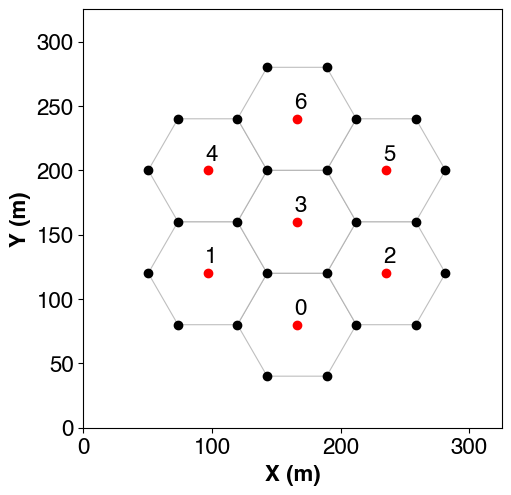

In [13]:
plotter_wf = ngp.NestedGridPlotter(fig_params={"figsize": (5, 5)})

for i, j in inj_grid_coordinates:
    plotter_wf.ax_dict["ax1-1"].plot(i, j, "ko")

for i, j in prod_grid_coordinates:
    plotter_wf.ax_dict["ax1-1"].plot(i, j, "ro")

patches = []
for polygon in polygons:
    # Add the polygon to the collection of patches
    xy = np.array(polygon)
    patches.append(Polygon(xy, closed=True, facecolor=None))
    # Plot the number of the polygon
p = PatchCollection(patches, alpha=0.75)
p.set_facecolors("white")
p.set_edgecolors("darkgrey")
p.set_linewidth(0.8)
p.set_linestyle("-")
plotter_wf.ax_dict["ax1-1"].add_collection(p)

for i, prod_coords in enumerate(prod_grid_coordinates):
    plotter_wf.ax_dict["ax1-1"].text(prod_coords[0] - 2, prod_coords[1] + 8, i)

plotter_wf.ax_dict["ax1-1"].set_aspect("equal", adjustable="box")
plotter_wf.ax_dict["ax1-1"].set_xlim(0, nx * dx)
plotter_wf.ax_dict["ax1-1"].set_ylim(0, ny * dy)
plotter_wf.ax_dict["ax1-1"].set_xlabel("X (m)", fontweight="bold")
plotter_wf.ax_dict["ax1-1"].set_ylabel("Y (m)", fontweight="bold")

fname = "7_cells_wellfield"
for format in ["png", "pdf"]:
    plotter_wf.fig.savefig(
        str(fig_save_path.joinpath(f"{fname}.{format}")), format=format
    )

- Make some selection

In [14]:
mpl_polygons = []
shapely_polygons = []

# Iterate the polygons to create matplotlib and shapely polygon instances
for polygon in polygons:
    # Add the polygon to the collection of patches
    xy = np.array(polygon)
    mpl_polygons.append(Polygon(xy, closed=True, facecolor=None))
    shapely_polygons.append(ShapelyPolygon(xy))

# Generate well field polygons
full_box = ShapelyBox(0.0, 0.0, nx * dx, ny * dy)  # polygon covering all the grid
inner_area = cascaded_union(shapely_polygons)  # polygon covering the well-field area
buffered_inner_area = inner_area.buffer(10.0)  # add a 10 m buffer around the
buffered_external_area = full_box.difference(
    buffered_inner_area
)  # ouside well-field area

- Create the flowrates for the wells: 12 m3/h decreasing following an exponential... for the producers with a balanced injection (2 m3/h per associated cell for the injectors).

In [15]:
def gen_flowrates(amplitude: float, coef: float, nt: int, dt: float) -> NDArrayFloat:
    """Generate flowrates with a given amplitude and decrease coefficient.

    Parameters
    ----------
    amplitude : float
        Amplitude in m3/h.
    coef : float
        Decrease coefficient.
    nt : int
        Number of timesteps
    dt : float
        Timesteps.

    Returns
    -------
    np.ndarray
        The flowrates.
    """
    return amplitude * np.exp(coef * np.arange(nt) * dt)

- Generate a flowrates with an initial amplitude at 1 m3/h and plot it
- For now steady state

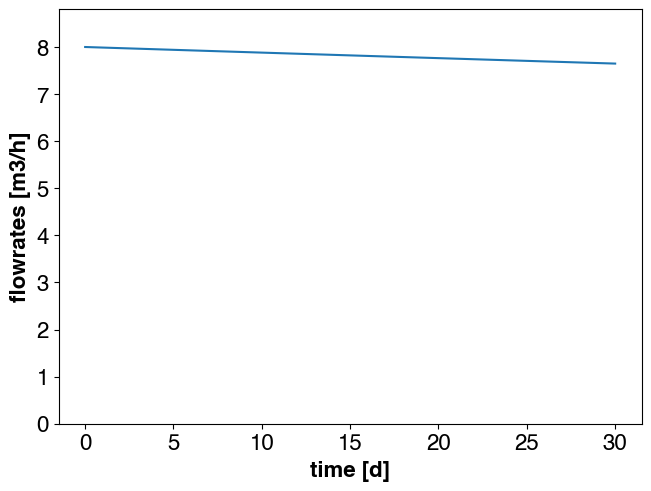

In [16]:
init_prod_flowrates = 8.0  # m3/s
flowrates = init_prod_flowrates * gen_flowrates(
    1.0, -0.0015, duration_in_days + 1, dt=1.0
)  # m3/h
time_in_days = np.arange(duration_in_days + 1)
# plt.plot(np.arange(nt + 1) * dt / 3600 / 24, flowrates)
# plt.ylim(0.0, init_prod_flowrates * 1.1)

plt.plot(np.arange(duration_in_days + 1), flowrates)
plt.ylim(0.0, init_prod_flowrates * 1.1)
plt.ylabel("flowrates [m3/h]", fontweight="bold")
plt.xlabel("time [d]", fontweight="bold")

fname = "flowrates_decrease"
for format in ["png", "pdf"]:
    plt.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

### Mineral grade: reference vs estimated

The mineral grades are defined in [mol/kg]. We calculate the conversion factor to obtain ppm and perform easier mass balances.

ConvU: parameter for converting the mineral content in [mol/kg] to metal grade in [ppm]. Note that the ConvU parameter is specific to the Uranium carrier phase: here Uraninite.

$C_{Uraninite}[\frac{mol}{kg}] = convU \times T_{Uranium}[ppm]$


and


$conv_u = \frac{1.023 \times density_{rock}}{238*porosity_{rock} \times 1000}$

Note the 1.023 is the conversion factor from molar mass to molal mass in CHESS.

In [17]:
rock_density = 1.63
conv_u_grade: NDArrayFloat = np.array(
    [1.023 * rock_density / (238.0 * porosity * 1000)]
)

- Conversion factor for uranium from mol/l to mg/l

In [18]:
conv_u_conc: float = (270.03 - 0.0016 * 2) * 1e3

- Functions to perform the conversions

In [19]:
def grade_ppm_to_mol_per_kg(x: NDArrayFloat) -> NDArrayFloat:
    return x * conv_u_grade


def grade_mol_per_kg_to_ppm(x: NDArrayFloat) -> NDArrayFloat:
    return x / conv_u_grade


def grade_mol_per_kg_to_ppm_1st_derivative(x: NDArrayFloat) -> NDArrayFloat:
    return 1 / conv_u_grade


def conc_molpl_to_mgpl(x: NDArrayFloat) -> NDArrayFloat:
    return x * conv_u_conc

- Using the SPDE approach, generate a random field

In [20]:
# spatial_dim = 2
# nu = 2 * alpha - spatial_dim / 2
# required_border_in_m = np.sqrt(8 * nu) / kappa
# required_border_in_m

In [21]:
len_scale = 20.0  # m
kappa = 1 / len_scale
alpha = 1.0
# min_val = 32 * conv_u_grade  # 32 ppm
# max_val = 300 * conv_u_grade  # 700 ppm
# # Compute the mean and the standard deviation that the distribution should have so that
# # <99% of the values are between min and max ~ 6 sigmas
# mean = (max_val + min_val) / 2
# stdev = (max_val - min_val) / 2 / 3  # std ~ 1/6 of the distribution interva

mean = 300.0  # trend of the field
std = 150.0  # standard deviation of the field

# Create a precison matrix
Q_ref = spde.get_precision_matrix(
    nx, ny, nz, dx, dy, dz, kappa, alpha, spatial_dim=2, sigma=std
)
cholQ_ref = cholesky(Q_ref)
# Non conditonal simulation -> change the random state to obtain a different field
simu_ = spde.simu_nc(cholQ_ref, random_state=2026).reshape(ny, nx).T
reference_grade = np.abs(simu_ + mean)

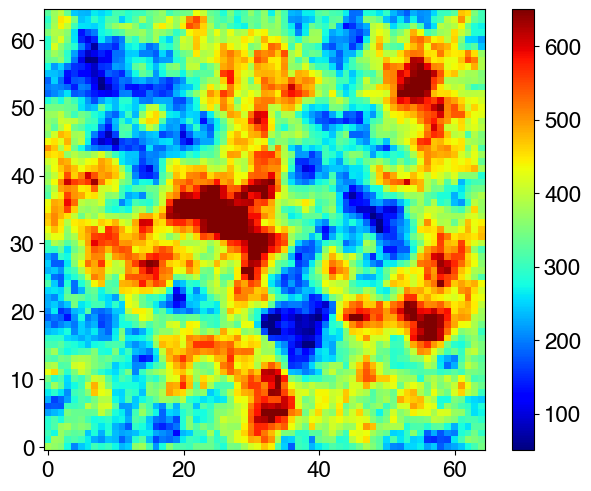

In [22]:
plt.imshow(
    reference_grade.T,
    origin="lower",
    cmap=plt.get_cmap("jet"),
    aspect="equal",
    vmin=50.0,
    vmax=650,
)
plt.colorbar()

- Select some points from this field (drilling places) -> green dots on the map

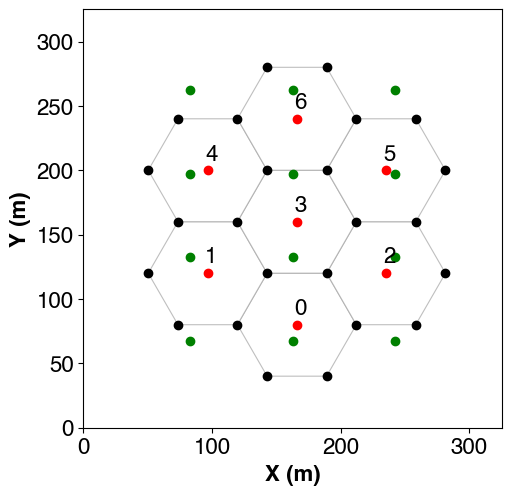

In [23]:
_ix = np.array([int(nx / 4), 2 * int(nx / 4), 3 * int(nx / 4)])
_iy = np.array([int(ny / 5), 2 * int(ny / 5), 3 * int(ny / 5), 4 * int(ny / 5)])

dat_coords = np.array(np.meshgrid(_ix, _iy)).reshape(2, -1)
# Get the node numbers
dat_nn = indices_to_node_number(dat_coords[0, :], nx, dat_coords[1, :])
dat_val = reference_grade.ravel("F")[dat_nn]

for i, j in dat_coords.T:
    plotter_wf.ax_dict["ax1-1"].plot((i + 0.5) * dx, (j + 0.5) * dy, "go")

plotter_wf.fig

In [24]:
kappa_est = 25
alpha = 2
# Create a precison matrix
Q_init = spde.get_precision_matrix(
    nx, ny, nz, dx, dy, dz, kappa, alpha, spatial_dim=2, sigma=std
)
# Decompose with cholesky
cholQ_init = cholesky(Q_init)

- Generate 3 conditional simulations with more or less error on the known data with a varigram which is not exactly correct + one constant field (witness case)

In [25]:
estimate_grade_flat = np.ones((nx, ny)) * 200  # 200 ppm

# Condition with the exact data
dat_var_ref = np.ones(dat_val.size) * 0.01**2
Q_init_c = spde.condition_precision_matrix(Q_init, dat_nn, dat_var_ref)
cholQ_init_c = cholesky(Q_init_c)
# estimate_grade_krig2 = spde.kriging(Q_init, dat_val, dat_nn).reshape(ny, nx).T

# Compute the average on the data points (trend)
av_dat = np.average(dat_val)
# Remove the trend from the residuals
dat_4_sim2 = dat_val - av_dat

estimate_grade_simu = np.abs(
    spde.simu_c(
        cholQ_init,
        Q_init_c,
        cholQ_init_c,
        dat_4_sim2,
        dat_nn,
        dat_var_ref,
        random_state=2028,
    )
    .reshape(ny, nx)
    .T
    + av_dat
)

# Generate new points with error -> systematic bias 200 ppm + some variance on the mesures
dat_val_wrong = (dat_val - 200) + 100 * np.random.default_rng(2023).normal(
    scale=1.0, size=dat_val.size
)
# Compute the average on the data points (trend)

av_dat_wrong = np.average(dat_val_wrong)
# Remove the trend from the residuals
dat_4_sim2 = dat_val_wrong - av_dat_wrong

estimate_grade_simu2 = np.abs(
    spde.simu_c(
        cholQ_init,
        Q_init_c,
        cholQ_init_c,
        dat_4_sim2,
        dat_nn,
        dat_var_ref,
        random_state=2028,
    )
    .reshape(ny, nx)
    .T
    + av_dat_wrong
)
# estimate_grade_krig2 = spde.kriging(Q_init, dat_val, dat_nn).reshape(ny, nx).T
# estimate_grade_krig2 = spde.kriging(Q_init, dat_val, dat_nn).reshape(ny, nx).T

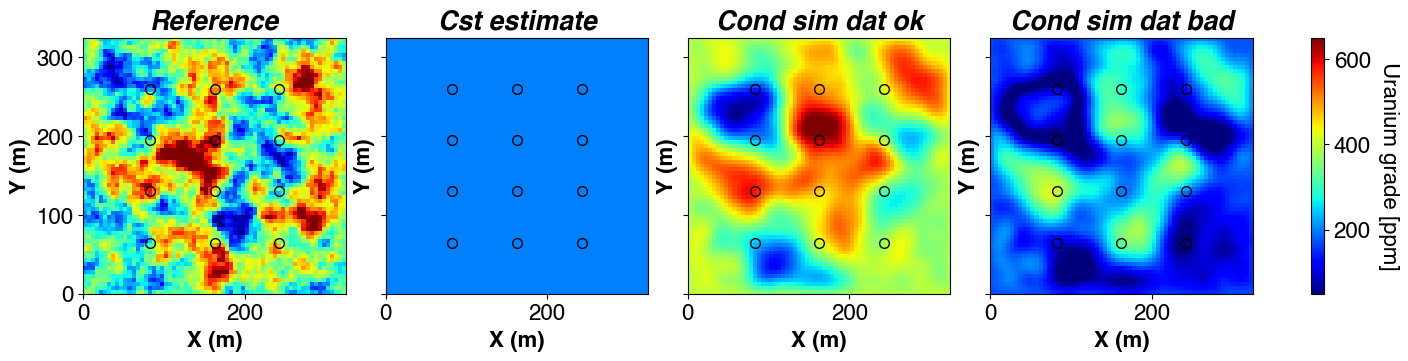

In [26]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (14, 3.5)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2", "ax1-3", "axes1-4"]], sharey=True, sharex=True
        )
    },
)

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Reference": reference_grade,
        "Cst estimate": estimate_grade_flat,
        "Cond sim dat ok": estimate_grade_simu,
        "Cond sim dat bad": estimate_grade_simu2,
    },
    cbar_title="Uranium grade [ppm]",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "vmin": 50,
        "vmax": 650,
    },
    xlabel="X (m)",
    ylabel="Y (m)",
)

for ax in plotter.axes:
    # plot the sampling points here
    ax.plot(
        (dat_coords[0] + 0.5) * dx,
        (dat_coords[1] * dy),
        linestyle="None",
        marker="o",
        markersize=7,
        color="k",
        markerfacecolor="None",
    )

fname = "u_grade_ref_vs_priors"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

# Test regularization term

In [27]:
estimate_grade_flat * conv_u_grade

array([[0.0060924, 0.0060924, 0.0060924, ..., 0.0060924, 0.0060924,
        0.0060924],
       [0.0060924, 0.0060924, 0.0060924, ..., 0.0060924, 0.0060924,
        0.0060924],
       [0.0060924, 0.0060924, 0.0060924, ..., 0.0060924, 0.0060924,
        0.0060924],
       ...,
       [0.0060924, 0.0060924, 0.0060924, ..., 0.0060924, 0.0060924,
        0.0060924],
       [0.0060924, 0.0060924, 0.0060924, ..., 0.0060924, 0.0060924,
        0.0060924],
       [0.0060924, 0.0060924, 0.0060924, ..., 0.0060924, 0.0060924,
        0.0060924]])

In [28]:
# Define a covariance matrix
cov_m = SparseInvCovarianceMatrix(Q_ref)  # We use the reference matrix

# Compute the objective function for the regularization of the flat field
test_reg = GeostatisticalRegularizator(cov_m=cov_m, prior=MeanPriorTerm())

# See if it is the same using the field in mol/kg -> need to rely on a preconditioner
test_reg_trans = GeostatisticalRegularizator(
    cov_m=cov_m,
    prior=MeanPriorTerm(),
    is_preconditioned=False,
    transform=grade_mol_per_kg_to_ppm,
    transform_1st_derivative=grade_mol_per_kg_to_ppm_1st_derivative,
)

# test_reg_constraint()

# likelyhood
logging.info(test_reg.eval_loss(estimate_grade_flat))
logging.info(test_reg_trans.eval_loss(grade_ppm_to_mol_per_kg(estimate_grade_simu)))
logging.info(test_reg_trans.eval_loss(grade_ppm_to_mol_per_kg(estimate_grade_simu2)))

INFO:root:0.0
INFO:root:27.016172937238707
INFO:root:35.623606427058924


- Plot the gradient for the flat field (since the mean is not correct, we expect a negative gradient, more or less constant troughout the domain - expect for the borders).

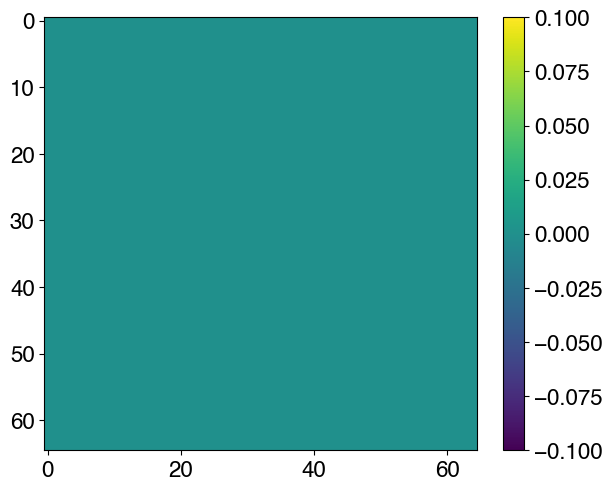

In [29]:
plt.imshow(test_reg.eval_loss_gradient(estimate_grade_flat))
plt.colorbar()

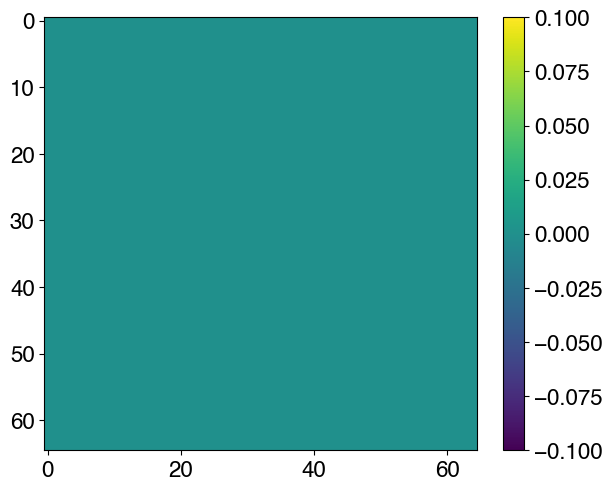

In [30]:
plt.imshow(
    test_reg_trans.eval_loss_gradient_analytical(
        grade_ppm_to_mol_per_kg(estimate_grade_flat)
    )
)
plt.colorbar()

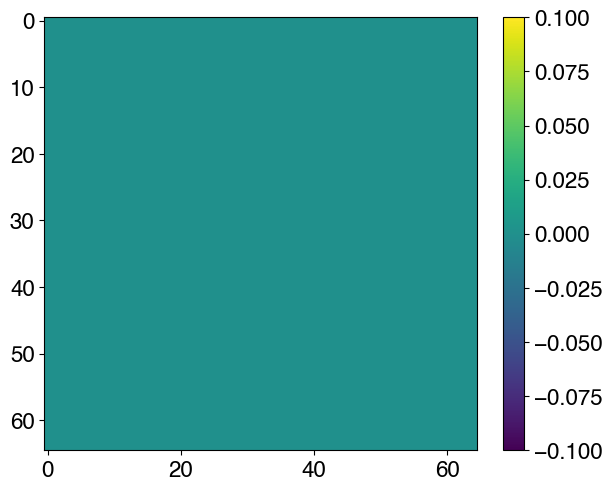

In [31]:
plt.imshow(
    test_reg_trans.eval_loss_gradient(
        grade_ppm_to_mol_per_kg(estimate_grade_flat), is_finite_differences=True
    )
)
plt.colorbar()

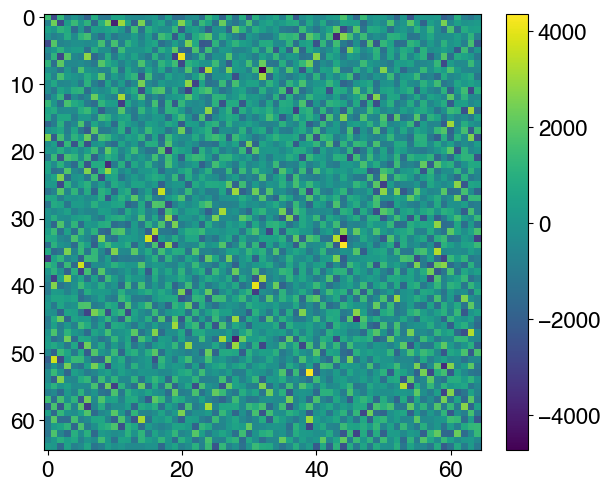

In [32]:
plt.imshow(
    test_reg_trans.eval_loss_gradient(
        grade_ppm_to_mol_per_kg(reference_grade), is_finite_differences=True
    )
)
plt.colorbar()

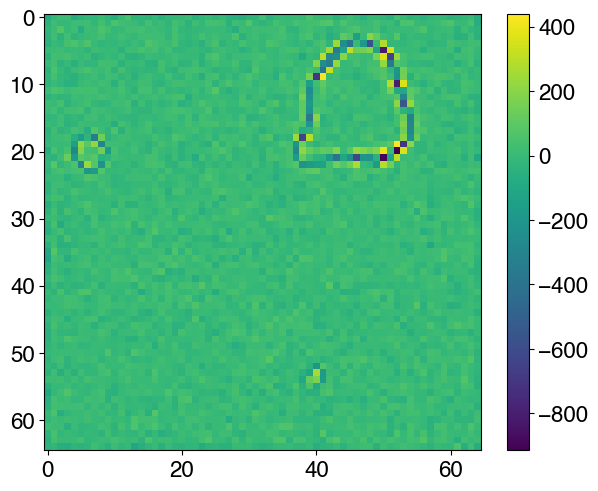

In [33]:
plt.imshow(
    test_reg_trans.eval_loss_gradient(
        grade_ppm_to_mol_per_kg(estimate_grade_simu2), is_finite_differences=True
    )
)
plt.colorbar()

- Perform some tests about the regularization

In [34]:
grade_ppm_to_mol_per_kg(estimate_grade_simu2).flatten().shape

(4225,)

For the PhD See: 
- https://www.statlect.com/fundamentals-of-statistics/multivariate-normal-distribution-maximum-likelihood
- https://stats.stackexchange.com/questions/351549/maximum-likelihood-estimators-multivariate-gaussian


- https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/other-readings/chapter13.pdf
- http://ttic.uchicago.edu/~shubhendu/Slides/Estimation.pdf


# TODO: include in the thesis
- Normal Theory and the Precision Matrix
Letting x be a p-vector with a multivariate Gaussian/normal, $$ x \sim N(\mu, \bm{\Sigma})$$, with pdf

$$p(x) = \left( (2 \pi)^{p} |\bm{\Sigma}| \right)^{-1/2} exp\left(-\dfrac{1}{2} (x-\mu)^{T}\bm{\Sigma}^{-1}(x -\mu)\right)$$

\Sigma is referred to as the covariance matrix, and $\bm{Q} = \bm{Simga}^{-1} is known as the precision matrix (when \bm{Simga}^{-1} exists). Writting the pdf in terms of the precision matrix, we get (joint probability density function):

$$ p(x) \propto |\bm{Q}|^{1/2} exp\left(-\dfrac{1}{2} (x-\mu)^{T}\bm{Q}(x -\mu)\right)$$

The covariance matrix $\bm{Q}$ is assumaed to be positive definite, so that its determinant $|\bm{Q}| is strictly positive.

And the likelyhood function is:

$$L(\mu, \bm{\Sigma}, x_{1}, ...x_{n}) = (2\pi)^{-nK/2} |\bm{\Sigma}|^{n/2} exp\left(-\dfrac{1}{2} (x-\mu)^{T}\bm{\Sigma}^{-1}(x -\mu)\right) $$

Then the loglikelyhood reads:

$$l(\mu, \bm{\Sigma}, x_{1}, ...x_{n}) = - \dfrac{nK}{2}ln(2\pi) - \dfrac{n}{2} ln(|\bm{\Sigma}|) - \dfrac{1}{2} (x-\mu)^{T}\bm{\Sigma}^{-1}(x -\mu) $$

Using the property of the determinant:

$$|\bm{\Sigma}^{-1}| = \dfrac{1}{|\bm{\Sigma}|}$$

and consequently 

$$ln(|\bm{\Sigma}|) = - ln(|\bm{Q}|)$$

Then the loglikelyhood reads:

$$l(\mu, \bm{Q}, x_{1}, ...x_{n}) = - \dfrac{nK}{2}ln(2\pi) + \dfrac{n}{2} ln(|\bm{Q}|) - \dfrac{1}{2} (x-\mu)^{T}\bm{Q}(x -\mu) $$

In the  following example, we try to minimize the function with both a prior + well constraints.

In [35]:
# logging.info(f"l(simu) = {loglikelyhood(estimate_grade_simu, Q_ref, cholQ_ref)}")
# logging.info(f"l(simu2) = {loglikelyhood(estimate_grade_simu2, Q_ref, cholQ_ref)}")
# logging.info(f"l(flat) = {loglikelyhood(estimate_grade_flat, Q_ref, cholQ_ref)}")

In [36]:
test_reg_trans.eval_loss(grade_ppm_to_mol_per_kg(estimate_grade_flat))

0.0

In [37]:
test_reg_trans.eval_loss(grade_ppm_to_mol_per_kg(estimate_grade_simu))

27.016172937238707

In [38]:
test_reg_trans.eval_loss(grade_ppm_to_mol_per_kg(estimate_grade_simu2))

35.623606427058924

In [39]:
from scipy.optimize import minimize
from scipy.sparse import csc_matrix
from sksparse.cholmod import Factor

test_reg_trans = GeostatisticalRegularizator(
    cov_m=cov_m,
    # prior=ConstantPriorTerm(np.ones((nx * ny)) * 300.0),
    prior=MeanPriorTerm(),
    is_preconditioned=False,
    transform=grade_mol_per_kg_to_ppm,
    transform_1st_derivative=grade_mol_per_kg_to_ppm_1st_derivative,
)


def loglikelyhood(x: NDArrayFloat, pmat: csc_matrix, cholQ: Factor) -> float:
    return (
        -x.size / 2 * np.log(2 * np.pi)
        + x.size / 2 * cholQ.logdet()
        - test_reg_trans.eval_loss(x.reshape(nx, ny, order="F"))
    )


def loglikelyhood_jac(x: NDArrayFloat) -> NDArrayFloat:
    return -test_reg_trans.eval_loss_gradient(x.reshape(nx, ny, order="F")).flatten("F")


def loglikelyhood_fun(x: NDArrayFloat) -> float:
    return loglikelyhood(x, Q_ref, cholQ_ref)


def fit_initial(x) -> float:
    _x = grade_mol_per_kg_to_ppm(x)
    return np.sum(((estimate_grade_simu2.ravel("F") - _x.ravel("F")) ** 2))


def fit_initial_jac(x) -> float:
    _x = grade_mol_per_kg_to_ppm(x)
    return estimate_grade_simu2.ravel("F") - _x.ravel("F")


def fit_well_data(x) -> float:
    _x = grade_mol_per_kg_to_ppm(x)
    return np.sum((((dat_val - _x.ravel("F")[dat_nn])) / dat_var_ref) ** 2)


def fit_well_data_gradient(x) -> NDArrayFloat:
    _x = grade_mol_per_kg_to_ppm(x)
    grad = np.zeros((nx * ny))
    grad[dat_nn] = -((dat_val - _x.ravel("F")[dat_nn]) / (dat_var_ref**2))
    return grad


def fun(x):
    return 500000 * test_reg_trans.eval_loss(
        x.reshape(nx, ny, order="F")
    ) + fit_initial(x)


def jac(x):
    return 500000 * test_reg_trans.eval_loss_gradient(
        x.reshape(nx, ny, order="F")
    ).flatten("F") + fit_initial_jac(x)


# def fun(x):
#     return fit_well_data(x)


# def jac(x):
#     return fit_well_data_gradient(x)


res = minimize(
    fun,
    grade_ppm_to_mol_per_kg(estimate_grade_simu2).flatten("F"),
    jac=jac,
    method="L-BFGS-B",
    tol=1e-4,
)
print(res)

inversed_field = grade_mol_per_kg_to_ppm(res.x.reshape(nx, ny, order="F"))

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 8412417.05504464
        x: [ 5.481e-03  5.509e-03 ...  5.398e-03  5.393e-03]
      nit: 26
      jac: [ 2.488e+06  2.598e+06 ... -2.515e+06 -3.108e+06]
     nfev: 41
     njev: 41
 hess_inv: <4225x4225 LbfgsInvHessProduct with dtype=float64>


In [40]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (14, 3.5)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2", "ax1-3", "ax1-4"]], sharey=True, sharex=True
        )
    },
)

ngp.multi_imshow(
    axes=plotter.axes[:3],
    fig=plotter.fig,
    data={
        "Reference": reference_grade,
        "Cst estimate": estimate_grade_simu2,
        "inverted field": inversed_field,
    },
    cbar_title="Uranium grade [ppm]",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "vmin": 50,
        "vmax": 650,
    },
    xlabel="X (m)",
    ylabel="Y (m)",
)

ngp.multi_imshow(
    axes=plotter.axes[-1:],
    fig=plotter.fig,
    data={"residuals": (estimate_grade_simu2 - inversed_field)},
    cbar_title="Uranium grade [ppm]",
    imshow_kwargs={
        "cmap": plt.get_cmap("bwr"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "vmin": -50,
        "vmax": 50,
    },
    xlabel="X (m)",
    ylabel="Y (m)",
    is_symmetric_cbar=True,
)

- Plot the reserves per mesh

In [49]:
def get_cell_reserves(
    u_field_grades: NDArrayFloat,
    cell_polygons: Sequence[Sequence[Tuple[float, float]]],
    nx: int,
    ny: int,
    dx: float,
    dy: float,
    dz: float,
) -> Sequence[float]:
    """Return the reserves in t under the given technological cell.

    Parameters
    ----------
    u_field_grades : NDArrayFloat
        Uraninite grades field in ppm. 2D Array.
    dx : float
        X dimension of one mesh (m).
    dy : float
        Y dimension of one mesh (m).
    dz : float
        Z dimension of one mesh (m).
    mask: NDArrayFloat
        Mask to apply before doing the selection.
    Returns
    -------
    float
        The associated uranium reserves in t.
    """
    # flatten points coordinates
    _x, _y, _z = hytec_node_number_to_indices(np.arange(nx * ny), nx, ny)
    _x = _x * dx + dx / 2
    _y = _y * dy + dy / 2
    grid_coords = np.array((_x, _y)).T

    cell_volume = dx * dy * dz  # m3
    # Conversion factor to go from a number of ppm per unit of volume to a mass in t (all cells are the same)
    conv_factor = cell_volume * rock_density * 1e-6

    reserves_list = []

    mask_sum = None
    for cell_polygon in cell_polygons:
        # Select the mesh that belongs to the polygon
        path = mpl.path.Path(cell_polygon)
        mask = path.contains_points(grid_coords)
        if mask_sum is not None:
            mask = np.logical_and(mask, ~mask_sum)
            mask_sum = np.logical_or(mask, mask_sum)
        else:
            mask_sum = mask
        reserves_list.append(float(u_field_grades[mask].sum() * conv_factor))
    return reserves_list

- Compute the reserve associated to the cells in t
- Need to transpose for the display

In [50]:
reference_reserves = get_cell_reserves(
    reference_grade.T.ravel(), polygons, nx, ny, dx, dy, dz
)
estimated_reserves_flat = get_cell_reserves(
    estimate_grade_flat.T.ravel(), polygons, nx, ny, dx, dy, dz
)
estimated_reserves_simu_1 = get_cell_reserves(
    estimate_grade_simu.T.ravel(), polygons, nx, ny, dx, dy, dz
)
estimated_reserves_simu_2 = get_cell_reserves(
    estimate_grade_simu2.T.ravel(), polygons, nx, ny, dx, dy, dz
)

- Compute deviations

In [51]:
initial_u_dev_flat = np.sum(estimated_reserves_flat) - np.sum(reference_reserves)
initial_u_dev_simu_1 = np.sum(estimated_reserves_simu_1) - np.sum(reference_reserves)
initial_u_dev_simu_2 = np.sum(estimated_reserves_simu_2) - np.sum(reference_reserves)

initial_u_dev_flat_frac = initial_u_dev_flat / np.sum(reference_reserves)
initial_u_dev_simu_1_frac = initial_u_dev_simu_1 / np.sum(reference_reserves)
initial_u_dev_simu_2_frac = initial_u_dev_simu_2 / np.sum(reference_reserves)

logging.info(
    f"initial_U_dev_flat = {initial_u_dev_flat:.2f} t ({initial_u_dev_flat_frac * 100:.2f}%)"
)
logging.info(
    f"initial_U_dev_simu_1 = {initial_u_dev_simu_1:.2f} t ({initial_u_dev_simu_1_frac * 100:.2f}%)"
)
logging.info(
    f"initial_U_dev_simu_2 = {initial_u_dev_simu_2:.2f} t ({initial_u_dev_simu_2_frac * 100:.2f}%)"
)

INFO:root:initial_U_dev_flat = -11.41 t (-47.38%)
INFO:root:initial_U_dev_simu_1 = 3.32 t (13.78%)
INFO:root:initial_U_dev_simu_2 = -10.46 t (-43.46%)


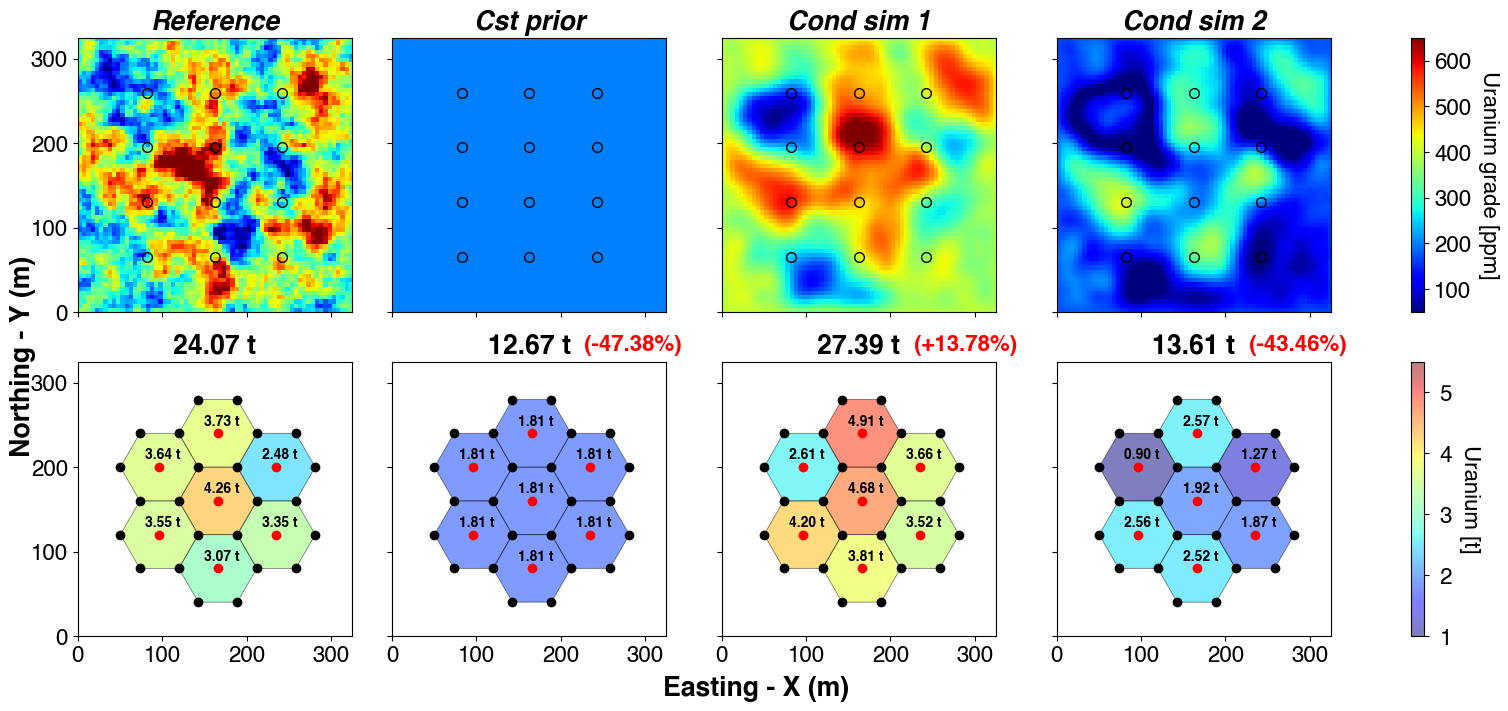

In [52]:
# plotter = ngp.NestedGridPlotter(
#     fig_params={"constrained_layout": True, "figsize": (14, 3.5)},
#     subplots_mosaic_params={
#         "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3", 'axes1-4']], sharey=True, sharex=True)
#     },
# )

plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (15, 7)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[
                ["ax1-1", "ax1-2", "ax1-3", "ax1-4"],
                ["ax2-1", "ax2-2", "ax2-3", "ax2-4"],
            ],
            sharey=True,
            sharex=True,
        )
    },
)

# 1) Plot the grades
cbar_up = ngp.multi_imshow(
    axes=plotter.axes[:4],
    fig=plotter.fig,
    data={
        "Reference": reference_grade,
        "Cst prior": estimate_grade_flat,
        "Cond sim 1": estimate_grade_simu,
        "Cond sim 2": estimate_grade_simu2,
    },
    cbar_title="Uranium grade [ppm]",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "vmin": 50,
        "vmax": 650,
    },
)

for ax in plotter.axes[:4]:
    # plot the sampling points here
    ax.plot(
        (dat_coords[0] + 0.5) * dx,
        (dat_coords[1] * dy),
        linestyle="None",
        marker="o",
        markersize=7,
        color="k",
        markerfacecolor="None",
    )

# 2) Plot the reserves
for _n, (ax, reserves) in enumerate(
    zip(
        list(plotter.ax_dict.values())[4:],
        (
            reference_reserves,
            estimated_reserves_flat,
            estimated_reserves_simu_1,
            estimated_reserves_simu_2,
        ),
    )
):
    for i, j in inj_grid_coordinates:
        ax.plot(i, j, "ko")

    for i, j in prod_grid_coordinates:
        ax.plot(i, j, "ro")

    patches = []
    for i, cell_polygon in enumerate(polygons):
        # Add the polygon to the collection of patches
        xy = np.array(cell_polygon)
        patches.append(Polygon(xy, closed=True, facecolor=None))

        centroid = (xy.mean(axis=0)[0] - 10, xy.mean(axis=0)[1] + 10)

        ax.text(*centroid, f"{reserves[i]:.2f} t", fontsize=10, fontweight="bold")

        # Plot the number of the polygon
    p = PatchCollection(patches, alpha=0.5, cmap=plt.get_cmap("jet"))
    # p.set_facecolors("white")
    p.set_edgecolors("black")
    p.set_linewidth(0.6)
    p.set_linestyle("-")
    p.set_array(np.array(reserves, dtype=float))
    p.set_clim(1, 5.5)
    ax.add_collection(p)

    # Add the tonnages
    tmp = ax.set_title(f"{np.sum(reserves):.2f} t", fontweight="bold")

    if _n != 0:
        # Absolute deviation
        ton_diff_abs = np.sum(reserves) - np.sum(reference_reserves)
        # Relative deviation
        ton_diff_rel = ton_diff_abs / np.sum(reference_reserves)

        pos = tmp.get_position()
        txt = ax.text(
            pos[0] + 0.2,
            pos[1] + 0.04,
            f"({ton_diff_rel * 100:+.2f}%)",
            fontweight="bold",
            transform=ax.transAxes,
            color="r" if np.abs(ton_diff_rel) > 0.1 else "g",
        )
        # txt.set_bbox(tmp.get_bbox_patch().get_boxstyle())

# Box dimensions
for ax in plotter.ax_dict.values():
    ax.set_xlim(0, nx * dx)
    ax.set_ylim(0, ny * dy)
    ax.set_aspect("equal", adjustable="box")

# Add a common colorbar
cbar = plotter.fig.colorbar(
    p, ax=plotter.axes[4:], orientation="vertical", fraction=0.1, format="%2.f"
)
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel("Uranium [t]", rotation=270)

# Box dimensions
for ax in plotter.ax_dict.values():
    ax.set_xlim(0, nx * dx)
    ax.set_ylim(0, ny * dy)
    ax.set_aspect("equal", adjustable="box")

# plotter.fig.suptitle("Grades and tonnages", fontweight="bold", fontsize=22)
plotter.fig.supxlabel("Easting - X (m)", fontweight="bold")
plotter.fig.supylabel("Northing - Y (m)", fontweight="bold")

fname = "reserves_and_grades_per_cells_ref_vs_priors"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

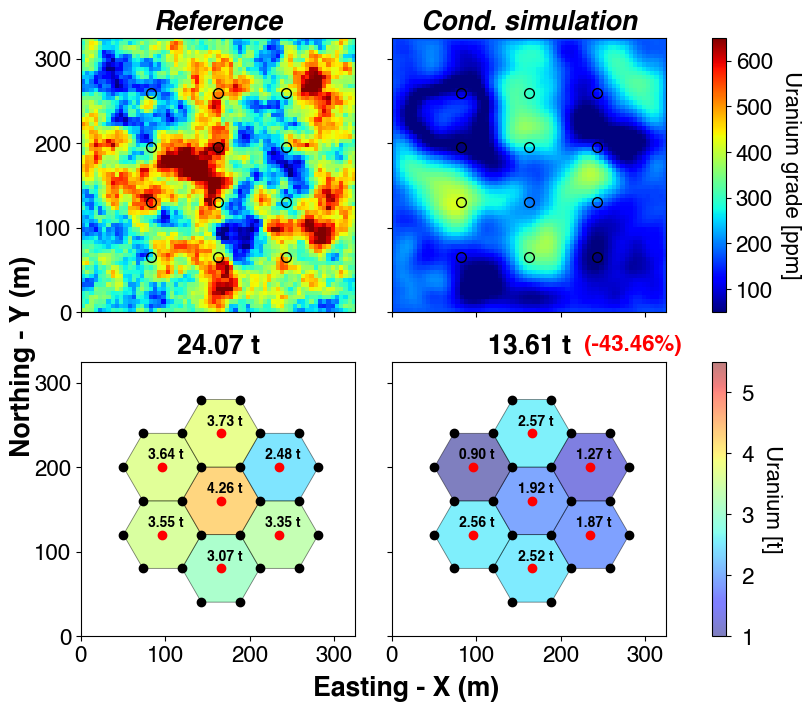

In [53]:
# plotter = ngp.NestedGridPlotter(
#     fig_params={"constrained_layout": True, "figsize": (14, 3.5)},
#     subplots_mosaic_params={
#         "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3", 'axes1-4']], sharey=True, sharex=True)
#     },
# )

plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 7)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[
                ["ax1-1", "ax1-2"],
                ["ax2-1", "ax2-2"],
            ],
            sharey=True,
            sharex=True,
        )
    },
)

# 1) Plot the grades
cbar_up = ngp.multi_imshow(
    axes=plotter.axes[:2],
    fig=plotter.fig,
    data={
        "Reference": reference_grade,
        "Cond. simulation": estimate_grade_simu2,
    },
    cbar_title="Uranium grade [ppm]",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "vmin": 50,
        "vmax": 650,
    },
)

for ax in plotter.axes[:2]:
    # plot the sampling points here
    ax.plot(
        (dat_coords[0] + 0.5) * dx,
        (dat_coords[1] * dy),
        linestyle="None",
        marker="o",
        markersize=7,
        color="k",
        markerfacecolor="None",
    )

# 2) Plot the reserves
for _n, (ax, reserves) in enumerate(
    zip(
        list(plotter.ax_dict.values())[2:],
        (
            reference_reserves,
            estimated_reserves_simu_2,
        ),
    )
):
    for i, j in inj_grid_coordinates:
        ax.plot(i, j, "ko")

    for i, j in prod_grid_coordinates:
        ax.plot(i, j, "ro")

    patches = []
    for i, cell_polygon in enumerate(polygons):
        # Add the polygon to the collection of patches
        xy = np.array(cell_polygon)
        patches.append(Polygon(xy, closed=True, facecolor=None))

        centroid = (xy.mean(axis=0)[0] - 10, xy.mean(axis=0)[1] + 10)

        ax.text(*centroid, f"{reserves[i]:.2f} t", fontsize=10, fontweight="bold")

        # Plot the number of the polygon
    p = PatchCollection(patches, alpha=0.5, cmap=plt.get_cmap("jet"))
    # p.set_facecolors("white")
    p.set_edgecolors("black")
    p.set_linewidth(0.6)
    p.set_linestyle("-")
    p.set_array(np.array(reserves, dtype=float))
    p.set_clim(1, 5.5)
    ax.add_collection(p)

    # Add the tonnages
    tmp = ax.set_title(f"{np.sum(reserves):.2f} t", fontweight="bold")

    if _n != 0:
        # Absolute deviation
        ton_diff_abs = np.sum(reserves) - np.sum(reference_reserves)
        # Relative deviation
        ton_diff_rel = ton_diff_abs / np.sum(reference_reserves)

        pos = tmp.get_position()
        txt = ax.text(
            pos[0] + 0.2,
            pos[1] + 0.04,
            f"({ton_diff_rel * 100:+.2f}%)",
            fontweight="bold",
            transform=ax.transAxes,
            color="r" if np.abs(ton_diff_rel) > 0.1 else "g",
        )
        # txt.set_bbox(tmp.get_bbox_patch().get_boxstyle())

# Box dimensions
for ax in plotter.ax_dict.values():
    ax.set_xlim(0, nx * dx)
    ax.set_ylim(0, ny * dy)
    ax.set_aspect("equal", adjustable="box")

# Add a common colorbar
cbar = plotter.fig.colorbar(
    p, ax=plotter.axes[2:], orientation="vertical", fraction=0.1, format="%2.f"
)
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel("Uranium [t]", rotation=270)

# Box dimensions
for ax in plotter.ax_dict.values():
    ax.set_xlim(0, nx * dx)
    ax.set_ylim(0, ny * dy)
    ax.set_aspect("equal", adjustable="box")

# plotter.fig.suptitle("Grades and tonnages", fontweight="bold", fontsize=22)
plotter.fig.supxlabel("Easting - X (m)", fontweight="bold")
plotter.fig.supylabel("Northing - Y (m)", fontweight="bold")

fname = "reserves_and_grades_per_cells"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

## Forward problem in demonstrator

In [54]:
time_params = dmfwd.TimeParameters(
    duration=duration_in_seconds, dt_init=dt_init, dt_min=dt_min, dt_max=dt_max
)
geometry = dmfwd.Geometry(nx=nx, ny=ny, dx=dx, dy=dx)
fl_params = dmfwd.FlowParameters(
    permeability=permeability,
    storage_coefficient=storage_coefficient,
    regime=dmfwd.FlowRegime.TRANSIENT,
    tolerance=1e-12,
)
tr_params = dmfwd.TransportParameters(
    diffusion=diffusion_coef,
    porosity=porosity,
    crank_nicolson_diffusion=1.0,
    crank_nicolson_advection=0.5,
    is_numerical_acceleration=False,
    tolerance=1e-15,
)
gch_params = dmfwd.GeochemicalParameters(conc=c0, grade=M0, kv=kv, As=As, Ks=Ks)

base_model = dmfwd.ForwardModel(geometry, time_params, fl_params, tr_params, gch_params)

- Add boundary conditions

In [55]:
# The fact to place boundary conditions causes weird behavior

# base_model.add_boundary_conditions(
#     dmfwd.ConstantHead(span=(slice(0, 1), slice(None)))
# )
# base_model.add_boundary_conditions(
#     dmfwd.ConstantHead(span=(slice(None), slice(0, 1)))
# )
# base_model.add_boundary_conditions(
#     dmfwd.ConstantHead(span=(slice(nx - 1, nx), slice(None)))
# )
# base_model.add_boundary_conditions(
#     dmfwd.ConstantHead(span=(slice(None), slice(ny - 1, ny)))
# )
base_model.fl_model.head[0, :, :] = 0.0
base_model.fl_model.head[-1, :, :] = 0.0
base_model.fl_model.head[:, 0, :] = 0.0
base_model.fl_model.head[:, -1, :] = 0.0

- Add source and sink terms

In [56]:
def flw_to_new_dt(
    flw: NDArrayFloat, times: NDArrayFloat, dt: float
) -> Tuple[NDArrayFloat, NDArrayFloat]:
    duration_in_days = flw.size - 1
    nt = int(duration_in_days * 24 * 3600 / dt)

    # Time in second, for each timestep
    new_times = np.arange(nt + 1) * dt

    # Flowrates
    new_flw = np.zeros(nt + 1)

    index = 0
    for new_index in range(nt + 1):
        time = new_index * dt  # in second
        while time > times[index] * 3600 * 24:
            index += 1
        new_flw[new_index] = flw[index]
    return new_times, new_flw


_times, _flowrates = flw_to_new_dt(flowrates, time_in_days, dt)
_times.size
_flowrates.size

121

In [57]:
prod_flw = -_flowrates / 3600  # m3/h to m3/s
# times = np.arange(stop=nt + 1, start=0) * dt

for count_prod, (ix, iy) in enumerate(prod_grid_indices):
    name = f"producer_{ix}_{iy}"

    sink_term = dmfwd.SourceTerm(
        name,
        node_ids=np.array([indices_to_hytec_node_number(ix, nx, iy)]),
        times=_times,
        flowrates=prod_flw,
        concentrations=np.zeros(_times.shape),
    )
    base_model.add_src_term(sink_term)


for count_inj, (ix, iy) in enumerate(inj_grid_indices):
    x, y = inj_grid_coordinates[count_inj]
    name = f"injector_{ix}_{iy}"

    nb_prod_well_linked = 0
    # Find the number of producers that the injector is linked with
    for xp, yp in prod_grid_coordinates:
        # we take 20% margin on the cell radius
        if np.sqrt((x - xp) ** 2 + (y - yp) ** 2) < cell_radius * 1.2:
            nb_prod_well_linked += 1

    source_term = dmfwd.SourceTerm(
        name,
        node_ids=np.array([indices_to_hytec_node_number(ix, nx, iy)]),
        times=_times,
        flowrates=-prod_flw
        / 6.0
        * nb_prod_well_linked,  # /6.0 because of hexagonal cells
        concentrations=np.ones(_times.shape) * c_inj,  # injection concentration
    )
    base_model.add_src_term(source_term)

- Check the hydraulic balance

In [58]:
total_prod_flow = 0
total_inj_flow = 0

for source_term in base_model.source_terms:
    _dt = np.diff(_times)  # timesteps in s
    total_inj_flow += np.sum(
        np.where(source_term.flowrates > 0, source_term.flowrates, 0.0)[1:] * _dt
    )
    total_prod_flow += np.sum(
        np.where(source_term.flowrates < 0, -source_term.flowrates, 0.0)[1:] * _dt
    )

print(f"total_prod_flow = {total_prod_flow} m3")
print(f"total_inj_flow = {total_inj_flow} m3")

# This test should fail if there is any issue !
assert np.round(total_prod_flow, 4) == np.round(total_inj_flow, 4)

total_prod_flow = 39396.6939777571 m3
total_inj_flow = 39396.69397775711 m3


In [59]:
source_term.times.size

121

- Create two models

In [61]:
model_reference = copy.deepcopy(base_model)
model_estimate_flat = copy.deepcopy(base_model)
model_estimate_simu_1 = copy.deepcopy(base_model)
model_estimate_simu_2 = copy.deepcopy(base_model)

# Exact initial uranium grade
model_reference.tr_model.set_initial_grade(grade_ppm_to_mol_per_kg(reference_grade))
# Estimated initial uranim grade
model_estimate_flat.tr_model.set_initial_grade(
    grade_ppm_to_mol_per_kg(estimate_grade_flat)
)
model_estimate_simu_1.tr_model.set_initial_grade(
    grade_ppm_to_mol_per_kg(estimate_grade_simu)
)
model_estimate_simu_2.tr_model.set_initial_grade(
    grade_ppm_to_mol_per_kg(estimate_grade_simu2)
)

- Run the models

In [62]:
solver_reference = dmfwd.ForwardSolver(model_reference)
solver_reference.solve()

KeyboardInterrupt: 

In [ ]:
solver_estimate_flat = dmfwd.ForwardSolver(model_estimate_flat)
solver_estimate_flat.solve()

In [ ]:
solver_estimate_simu_1 = dmfwd.ForwardSolver(model_estimate_simu_1)
solver_estimate_simu_1.solve()

In [ ]:
solver_estimate_simu_2 = dmfwd.ForwardSolver(model_estimate_simu_2)
solver_estimate_simu_2.solve()

In [ ]:
time_index_1 = 10
time_index_2 = 20

plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (12, 5)},
    # subfigs_params={"nrows": 1},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True),
    },
)

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Head [m]": model_reference.fl_model.head[:, :, time_index_1],
        "Head [m] 2": model_reference.fl_model.head[:, :, time_index_2],
    },
    cbar_title="Head $[m]$",
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
)

for ax, time_index in zip(plotter.axes, [time_index_1, time_index_2]):
    Y, X = np.meshgrid((np.arange(nx) + 0.5) * dx, (np.arange(ny) + 0.5) * dy)
    ax.quiver(
        X,
        Y,
        model_reference.fl_model.u_darcy_x_center[:, :, time_index],
        model_reference.fl_model.u_darcy_y_center[:, :, time_index],
        color="C0",
        scale_units="xy",
    )

# plotter.ax_dict["ax1-1"].set_title("Heads [m]", fontweight="bold")
# plotter.ax_dict["ax1-2"].set_title("Darcy velocity [m/s]", fontweight="bold")

plotter.subfigs["fig0"].suptitle(
    "Heads and Darcy velocities", fontweight="bold", fontsize=16
)
plotter.subfigs["fig0"].supxlabel("X (m)", fontweight="bold")
plotter.subfigs["fig0"].supylabel("Y (m)", fontweight="bold")

# fname = "heads_and_velocities"
# for format in ["png", "pdf"]:
#     plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Plot the concentration evolution

In [ ]:
# Plot a concentration animation Here !
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (16, 5)},
    subfigs_params={"nrows": 1},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2", "ax1-3", "ax1-4"]], sharey=True, sharex=True
        ),
    },
)
nb_frames = nb_frames = min(15, model_reference.time_params.nt)

plotter.animated_multi_imshow(
    ax_names=list(plotter.ax_dict.keys()),
    fig=plotter.fig,
    data={
        "Reference": conc_molpl_to_mgpl(model_reference.tr_model.conc[:, :, :]),
        "Estimate (flat)": conc_molpl_to_mgpl(
            model_estimate_flat.tr_model.conc[:, :, :]
        ),
        "Estimate (simu_1)": conc_molpl_to_mgpl(
            model_estimate_simu_1.tr_model.conc[:, :, :]
        ),
        "Estimate (simu_2)": conc_molpl_to_mgpl(
            model_estimate_simu_2.tr_model.conc[:, :, :]
        ),
    },
    cbar_title="Concentration $[mg/l]$",
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
    nb_frames=nb_frames,
    # is_add_grid=True,
)

# Add animated text
plotter.plot_animated_text(
    plotter.ax_dict["ax1-1"],
    x=5.0,
    y=350.0,
    s=[f"{d:.2f} d" for d in np.arange(nb_frames) * duration_in_days / (nb_frames - 1)],
    fontweight="bold",
)

plotter.subfigs["fig0"].suptitle(
    "Concentration evolution (PyRTID)", fontweight="bold", size=16
)
plotter.subfigs["fig0"].supxlabel("X (m)", fontweight="bold")
plotter.subfigs["fig0"].supylabel("Y (m)", fontweight="bold")

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("fwd_conc_2d_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

In [ ]:
# Plot a grade evolution animation Here !
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (16, 5)},
    subfigs_params={"nrows": 1},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2", "ax1-3", "ax1-4"]], sharey=True, sharex=True
        ),
    },
)
nb_frames = nb_frames = min(15, model_reference.time_params.nt)

plotter.animated_multi_imshow(
    ax_names=list(plotter.ax_dict.keys()),
    fig=plotter.fig,
    data={
        "Reference": grade_mol_per_kg_to_ppm(model_reference.tr_model.grade[:, :, :]),
        "Estimate (flat)": grade_mol_per_kg_to_ppm(
            model_estimate_flat.tr_model.grade[:, :, :]
        ),
        "Estimate (simu_1)": grade_mol_per_kg_to_ppm(
            model_estimate_simu_1.tr_model.grade[:, :, :]
        ),
        "Estimate (simu_2)": grade_mol_per_kg_to_ppm(
            model_estimate_simu_2.tr_model.grade[:, :, :]
        ),
    },
    cbar_title="Uranium grade [ppm]",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "vmin": 50,
        "vmax": 650,
        "aspect": "equal",
    },
    nb_frames=nb_frames,
    # is_add_grid=True,
)

# Add animated text
plotter.plot_animated_text(
    plotter.ax_dict["ax1-1"],
    x=5.0,
    y=290.0,
    s=[f"{d:.2f} d" for d in np.arange(nb_frames) * duration_in_days / (nb_frames - 1)],
    fontweight="bold",
)

plotter.subfigs["fig0"].suptitle("Grade evolution (PyRTID)", fontweight="bold", size=16)
plotter.subfigs["fig0"].supxlabel("X (m)", fontweight="bold")
plotter.subfigs["fig0"].supylabel("Y (m)", fontweight="bold")

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("fwd_conc_2d_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

In [ ]:
# Plot a concentration animation Here !
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (14, 7)},
    subfigs_params={"nrows": 1},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[
                ["ax1-1", "ax1-2", "ax1-3", "ax1-4"],
                ["ax2-1", "ax2-2", "ax2-3", "ax2-4"],
            ],
            sharey=True,
            sharex=True,
        ),
    },
)

# Set the number of frames
nb_frames = min(10, nt)

# 1) Animation on concentrations
plotter.animated_multi_imshow(
    ax_names=list(plotter.ax_dict.keys())[:4],
    fig=plotter.fig,
    data={
        "Reference": conc_molpl_to_mgpl(model_reference.tr_model.conc[:, :, :]),
        "Prior (flat)": conc_molpl_to_mgpl(model_estimate_flat.tr_model.conc[:, :, :]),
        "Prior (simu_1)": conc_molpl_to_mgpl(
            model_estimate_simu_1.tr_model.conc[:, :, :]
        ),
        "Prior (simu_2)": conc_molpl_to_mgpl(
            model_estimate_simu_2.tr_model.conc[:, :, :]
        ),
    },
    cbar_title="Concentration $[mg/l]$",
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
    nb_frames=nb_frames,
    # is_add_grid=True,
)

# 2) Add animated text
plotter.plot_animated_text(
    plotter.ax_dict["ax1-1"],
    x=-40.0,
    y=335.0,
    s=[f"{d:.2f} d" for d in np.arange(nb_frames) * duration_in_days / (nb_frames - 1)],
    fontweight="bold",
)

# plotter.subfigs["fig0"].suptitle("Concentration evolution (PyRTID)", fontweight="bold", size=16)
plotter.subfigs["fig0"].supxlabel("X (m)", fontweight="bold")
plotter.subfigs["fig0"].supylabel("Y (m)", fontweight="bold")

# 3) Animation on grades
plotter.animated_multi_imshow(
    ax_names=list(plotter.ax_dict.keys())[4:],
    fig=plotter.fig,
    data={
        "Reference": grade_mol_per_kg_to_ppm(model_reference.tr_model.grade[:, :, :]),
        "Prior (flat)": grade_mol_per_kg_to_ppm(
            model_estimate_flat.tr_model.grade[:, :, :]
        ),
        "Prior (simu_1)": grade_mol_per_kg_to_ppm(
            model_estimate_simu_1.tr_model.grade[:, :, :]
        ),
        "Prior (simu_2)": grade_mol_per_kg_to_ppm(
            model_estimate_simu_2.tr_model.grade[:, :, :]
        ),
    },
    cbar_title="Uranium grade [ppm]",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "vmin": 50,
        "vmax": 650,
        "aspect": "equal",
    },
    nb_frames=nb_frames,
    # is_add_grid=True,
)

for ax in plotter.axes[4:]:
    ax.set(title=None)

# plotter.subfigs["fig0"].suptitle("Grade evolution (PyRTID)", fontweight="bold", size=16)
# plotter.subfigs["fig0"].supxlabel("X (m)", fontweight="bold")
# plotter.subfigs["fig0"].supylabel("Y (m)", fontweight="bold")

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("fwd_conc_grade_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

## Observations and associated uncertainties

- We select only 10% of the data points available to get something more realistic

In [ ]:
obs_time_idx = np.zeros((nt + 1), dtype=np.bool8)
obs_time_idx[::10] = True
obs_time_idx

- Create a function to add some noise to the observations

In [ ]:
noise_std: float = 1e-5  # This is an absolute value
rng = np.random.default_rng(2021)


def get_white_noise(shape: Iterable[int]) -> NDArrayFloat:
    """
    Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return rng.normal(mean_noise, noise_std, size=np.array(shape))


# Generate a white noise
obs_noise: NDArrayFloat = get_white_noise(
    model_reference.fl_model.head[: len(prod_grid_indices), 0, :].shape
)

In [ ]:
obs_time_idx

In [ ]:
time_all = np.arange(nt + 1) / (3600 * 24 / dt)
time_obs = time_all[obs_time_idx]
ix, iy = prod_grid_indices[0]
plt.plot(time_all, model_reference.tr_model.conc[ix, iy, :])
plt.plot(
    time_obs,
    model_reference.tr_model.conc[ix, iy, obs_time_idx] + obs_noise[0, obs_time_idx],
    marker="o",
    linestyle="none",
)

In [ ]:
# Indicate the order in which to plot
obs_plot_locations = ["ax2-3", "ax1-2", "ax3-2", "ax2-2", "ax1-1", "ax3-1", "ax2-1"]

plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (12, 8)},
    subfigs_params={
        "ncols": 3  # np.unique(np.array(prod_grid_locations)[:, 0].round()).size,
    },
    subplots_mosaic_params={
        "left_col": dict(
            mosaic=[["ghost1"], ["ax1-1"], ["ax1-2"], ["ghost2"]],
            gridspec_kw=dict(
                height_ratios=[1.0, 1.2, 1.2, 1.0],
            ),
            sharey=True,
            sharex=True,
        ),
        "centered_col": dict(
            mosaic=[["ax2-1"], ["ax2-2"], ["ax2-3"]], sharey=True, sharex=True
        ),
        "right_col": dict(
            mosaic=[["ghost3"], ["ax3-1"], ["ax3-2"], ["ghost4"]],
            gridspec_kw=dict(
                height_ratios=[1.0, 1.2, 1.2, 1.0],
            ),
            sharey=True,
            sharex=True,
        ),
    },
)

# hide axes and borders
plotter.ax_dict["ghost1"].axis("off")
plotter.ax_dict["ghost2"].axis("off")
plotter.ax_dict["ghost3"].axis("off")
plotter.ax_dict["ghost4"].axis("off")

# Static plot
for count, ((ix, iy), ax_name) in enumerate(zip(prod_grid_indices, obs_plot_locations)):
    x = (ix + 0.5) * dx
    y = (iy + 0.5) * dy
    obs_well_name = f"obs. well @ x={x:.1f}m, y={y:.1f}m"

    ax = plotter.ax_dict[ax_name]
    ax.set_title(obs_well_name, fontweight="bold", fontsize=12)

    data = {
        "Reference.": {
            "x": time_all,
            "y": conc_molpl_to_mgpl(model_reference.tr_model.conc[ix, iy, :]),
            "kwargs": {"c": "b"},
        },
        "Reference noisy": {
            "x": time_all[::20],
            "y": conc_molpl_to_mgpl(
                model_reference.tr_model.conc[ix, iy, :] + obs_noise[count]
            )[::20],
            "kwargs": {"c": "b", "marker": "o", "linestyle": "None", "alpha": 0.2},
        },
        "A priori cst.": {
            "x": time_all,
            "y": conc_molpl_to_mgpl(model_estimate_flat.tr_model.conc[ix, iy, :]),
            "kwargs": {"c": "r"},
        },
        "A priori simu_1.": {
            "x": time_all,
            "y": conc_molpl_to_mgpl(model_estimate_simu_1.tr_model.conc[ix, iy, :]),
            "kwargs": {"c": "g", "linestyle": "--"},
        },
        "A priori simu_2C": {
            "x": time_all,
            "y": conc_molpl_to_mgpl(model_estimate_simu_2.tr_model.conc[ix, iy, :]),
            "kwargs": {"c": "k", "linestyle": "--"},
        },
    }

    for k, v in data.items():
        ax.plot(v["x"], v["y"], **v["kwargs"], label=k)

    # ax.set_xlabel("Time", fontweight="bold")
    # ax.set_xlabel("T_Cinet [mol/s]", fontweight="bold")

plotter.add_fig_legend(ncol=3)
plotter.fig.supxlabel("Time [d]", fontweight="bold")
plotter.fig.supylabel("T_Cinet [mg/l]", fontweight="bold")

fname = "prior_T_Cinet_at_producers"
for format in ["png", "pdf"]:
    plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Define a function to plot the results afterwards

In [ ]:
def plot_inv_res_conc_at_producers(
    *,
    ref_model: dmfwd.ForwardModel,
    prior_model: dmfwd.ForwardModel,
    inversed_model: dmfwd.ForwardModel,
    case_name: str,
) -> NestedGridPlotter:
    """

    Parameters
    ----------
    ref_model : _type_
        _description_
    prior_model : _type_
        _description_
    inversed_model : _type_
        _description_

    Returns
    -------
    NestedGridPlotter
        _description_
    """
    # Indicate the order in which to plot
    obs_plot_locations = ["ax2-3", "ax1-2", "ax3-2", "ax2-2", "ax1-1", "ax3-1", "ax2-1"]

    plotter = ngp.NestedGridPlotter(
        fig_params={"constrained_layout": True, "figsize": (12, 8)},
        subfigs_params={
            "ncols": 3  # np.unique(np.array(prod_grid_locations)[:, 0].round()).size,
        },
        subplots_mosaic_params={
            "left_col": dict(
                mosaic=[["ghost1"], ["ax1-1"], ["ax1-2"], ["ghost2"]],
                gridspec_kw=dict(
                    height_ratios=[1.0, 1.2, 1.2, 1.0],
                ),
                sharey=True,
                sharex=True,
            ),
            "centered_col": dict(
                mosaic=[["ax2-1"], ["ax2-2"], ["ax2-3"]], sharey=True, sharex=True
            ),
            "right_col": dict(
                mosaic=[["ghost3"], ["ax3-1"], ["ax3-2"], ["ghost4"]],
                gridspec_kw=dict(
                    height_ratios=[1.0, 1.2, 1.2, 1.0],
                ),
                sharey=True,
                sharex=True,
            ),
        },
    )

    # hide axes and borders
    plotter.ax_dict["ghost1"].axis("off")
    plotter.ax_dict["ghost2"].axis("off")
    plotter.ax_dict["ghost3"].axis("off")
    plotter.ax_dict["ghost4"].axis("off")

    # Static plot
    for count, ((ix, iy), ax_name) in enumerate(
        zip(prod_grid_indices, obs_plot_locations)
    ):
        x = (ix + 0.5) * dx
        y = (iy + 0.5) * dy
        obs_well_name = f"obs. well @ x={x:.1f}m, y={y:.1f}m"

        ax = plotter.ax_dict[ax_name]
        ax.set_title(obs_well_name, fontweight="bold", fontsize=12)

        data = {
            "Reference noisy": {
                "x": time_all[::10],
                "y": conc_molpl_to_mgpl(
                    ref_model.tr_model.conc[ix, iy, :] + obs_noise[count]
                )[::10],
                "kwargs": {"c": "b", "marker": "o", "linestyle": "None", "alpha": 0.2},
            },
            "A priori": {
                "x": time_all,
                "y": conc_molpl_to_mgpl(prior_model.tr_model.conc[ix, iy, :]),
                "kwargs": {"c": "r"},
            },
            "Post-inversion": {
                "x": time_all,
                "y": conc_molpl_to_mgpl(inversed_model.tr_model.conc[ix, iy, :]),
                "kwargs": {"c": "g", "linestyle": "--"},
            },
        }

        for k, v in data.items():
            ax.plot(v["x"], v["y"], **v["kwargs"], label=k)

        # ax.set_xlabel("Time", fontweight="bold")
        # ax.set_xlabel("T_Cinet [mol/s]", fontweight="bold")

    plotter.add_fig_legend(ncol=3)
    plotter.fig.supxlabel("Time [d]", fontweight="bold")
    plotter.fig.supylabel("T_Cinet [mg/l]", fontweight="bold")

    fname = f"prior_T_Cinet_at_producers_{case_name}"
    for format in ["png", "pdf"]:
        plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)
    return plotter

## Inversion tests

In [ ]:
is_run_first_test = False

In [ ]:
if is_run_all or is_run_first_test:
    adjusted_param = dminv.AdjustableParameter(
        name=dminv.ParameterName.INITIAL_GRADE,
        lbounds=0.0,
        ubounds=700.0 * float(conv_u_grade),
        span=(slice(4, -4), slice(4, -4)),  # exclude the border
    )

    from typing import Dict  # Just for linting

    observables = []
    for i, (ix, iy) in enumerate(prod_grid_indices):
        # node_id = indices_to_node_number(ix, nx=nx, iy=iy)
        vals = model_reference.tr_model.conc[ix, iy, :] + obs_noise[i]
        timesteps = np.arange(vals.shape[0])

        observables.append(
            dminv.Observable(
                state_variable=dminv.StateVariable.CONCENTRATION,
                location=(slice(ix, ix + 1, 1), slice(iy, iy + 1, 1)),
                timesteps=timesteps,
                values=vals,
                uncertainties=noise_std,
            )
        )

    # Create an executor to keep track of the adjoint model
    solver_config = dminv.ScipySolverConfig(
        solver_name="L-BFGS-B",
        solver_options={"maxfun": 10, "maxiter": 10, "ftol": 1e-4, "gtol": 1e-4},
        is_check_gradient=False,
    )
    model_adjusted = copy.deepcopy(model_estimate_flat)
    # Use less timestep
    # model_adjusted.time_params.nt =
    inverse_model = dminv.InverseModel(adjusted_param, observables)
    executor = dminv.ScipyInversionExecutor(
        model_adjusted, inverse_model, solver_config
    )

    # Compute a first objective function
    executor.eval_scaled_loss(
        get_param_values(adjusted_param, is_preconditioned=True), is_save_state=False
    )

In [ ]:
if is_run_all or is_run_first_test:
    res = executor.run()

In [ ]:
if is_run_all or is_run_first_test:
    logging.info(res)

In [ ]:
if is_run_all or is_run_first_test:
    plotter = ngp.AnimatedPlotter(
        fig_params={"constrained_layout": True, "figsize": (12, 5)},
        subplots_mosaic_params={
            "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
        },
    )

    nb_frames = 15
    plotter.animated_multi_imshow(
        ax_names=["ax1-1"],
        data={
            "Adjoint sources": executor.adj_model.a_tr_model.a_sources,
        },
        cbar_title="Head error [m]",
        nb_frames=nb_frames + 1,
        imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
        xlabel="X (m)",
        ylabel="Y (m)",
        is_symmetric_cbar=True,
    )

    plotter.animated_multi_imshow(
        ax_names=["ax1-2"],
        data={
            "Adjoint head": executor.adj_model.a_tr_model.a_conc,
        },
        cbar_title="Adjoit head",
        nb_frames=nb_frames,
        imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
        xlabel="X (m)",
        ylabel="Y (m)",
        is_symmetric_cbar=True,
    )

    plotter.subfigs["fig0"].suptitle("Adjoint sources and head", fontweight="bold")

    plotter.close()
    plotter.animate(nb_frames=nb_frames)

    # Save the animation locally on the computer
    fname_html = fig_save_path.joinpath(
        "head_field_reference_vs_initial_guess_animated.html"
    )
    writer = HTMLWriter(fps=5, embed_frames=True)
    writer.frame_format = "svg"  # Ensure svg format
    plotter.animation.save(str(fname_html), writer=writer)

    # Display the animation
    HTML(fname_html.read_text())

In [ ]:
if is_run_all or is_run_first_test:
    plotter = ngp.AnimatedPlotter(
        fig_params={"figsize": (10.0, 8.0)}, subfigs_params={"nrows": 2, "ncols": 2}
    )

    # 1 frame per solver iteration
    nb_frames: int = inverse_model.nb_f_calls

    aligned_adjoint_gradients = get_gridded_archived_gradients(
        adjusted_param, is_adjoint=True
    )

    # 1) Gradient evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-1"],
        data={
            "Gradient": aligned_adjoint_gradients,
        },
        # cbar_title="Adjoit head",
        nb_frames=nb_frames,
        imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
        xlabel="X (m)",
        ylabel="Y (m)",
        is_symmetric_cbar=True,
    )
    plotter.get_axis("ax1-1").set_title("Gradient", fontweight="bold")

    # 2) Parameter evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-2"],
        data={
            "Uranium grade": grade_mol_per_kg_to_ppm(
                np.transpose(np.array(adjusted_param.archived_values), axes=[1, 2, 0])
            ),
        },
        nb_frames=nb_frames,
        imshow_kwargs={
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "aspect": "equal",
            # "norm": LogNorm(vmin=1e-5, vmax=1e-3),
            "cmap": plt.get_cmap("jet"),
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": 50,
            "vmax": 650,
        },
        xlabel="X (m)",
        ylabel="Y (m)",
    )

    plotter.get_axis("ax1-2").set_title("Uranium grade [ppm]", fontweight="bold")

    # 3) Objective function
    vals = inverse_model.loss_scaled_history
    obj_fun_vals = np.full((len(vals), nb_frames), fill_value=np.nan)
    for i in range(len(vals)):
        obj_fun_vals[: i + 1, i] = vals[: i + 1]

    plotter.animated_multi_plot(
        ax_name="ax2-1",
        data={
            "Obj fun": {"y": obj_fun_vals, "kwargs": {"c": "r", "linestyle": "--"}},
        },
        nb_frames=nb_frames,
        title="Objective function",
        xlabel="Iteration #",
    )
    plotter.ax_dict["ax2-1"].set_yscale("log")

    # 4) Observation vs predicted values
    plotter.animated_multi_plot(
        ax_name="ax2-1",
        data={
            "Obj fun": {"y": obj_fun_vals, "kwargs": {"c": "r", "linestyle": "--"}},
        },
        nb_frames=nb_frames,
        title="Objective function",
        xlabel="Iteration #",
    )
    plotter.ax_dict["ax2-1"].set_yscale("log")

    # 4) Observation vs predicted values
    pyrtid.plot.plot_observed_vs_simulated(
        plotter.ax_dict["ax2-2"],
        obs_vector=conc_molpl_to_mgpl(
            dminv.get_observables_values_as_1d_vector(observables)
        ),
        pred_vector_initial=conc_molpl_to_mgpl(
            dminv.get_predictions_matching_observations(
                model_estimate_flat, observables
            )
        ),
        units="mg/l",
    )
    plotter.animated_multi_plot(
        ax_name="ax2-2",
        data={
            "current": {
                "x": conc_molpl_to_mgpl(
                    dminv.get_observables_values_as_1d_vector(observables)
                ),
                "y": conc_molpl_to_mgpl(np.array(executor.inv_model.list_d_pred).T),
                "kwargs": {"c": "b", "linestyle": "none", "marker": ".", "zorder": 2},
            },
        },
        nb_frames=nb_frames,
    )
    # Add a legend
    plotter.get_axis("ax2-2").legend(loc="upper left")

    plotter.close()
    plotter.animate(nb_frames=nb_frames)
    # Save the animation locally on the computer
    fname_html = fig_save_path.joinpath("inversion_animation_first_test.html")
    writer = HTMLWriter(fps=2, embed_frames=True)
    writer.frame_format = "svg"  # Ensure svg format
    plotter.animation.save(str(fname_html), writer=writer)

    # Extract the svg from the html file (for animation in Latex)
    ngp.extract_frames_from_embedded_html_animation(fname_html)

    # Display the animation
    HTML(fname_html.read_text())

- Plot the results at the cell scale etc.

In [ ]:
def plot_inversion_results(
    *,
    case_name: str,
    reference_grade: NDArrayFloat,
    prior_grade: NDArrayFloat,
    inversed_grade: NDArrayFloat,
) -> None:
    plotter = ngp.NestedGridPlotter(
        fig_params={"constrained_layout": True, "figsize": (11, 7)},
        # subfigs_params={"nrows": 2},
        subplots_mosaic_params={
            "fig0": dict(
                mosaic=[["ax1-1", "ax1-2", "ax1-3"], ["ax2-1", "ax2-2", "ax2-3"]],
                sharey=True,
                sharex=True,
            ),
            # "fig1": dict(mosaic=[["ax2-1", "ax2-2", "ax2-3"]], sharey=True, sharex=True)
        },
    )

    ngp.multi_imshow(
        axes=plotter.axes[0:3],
        fig=plotter.subfigs["fig0"],
        data={
            "Reference": reference_grade,
            "A priori": prior_grade,
            "inverted": inversed_grade,
        },
        cbar_title="Uranium grade [ppm]",
        imshow_kwargs={
            "cmap": plt.get_cmap("jet"),
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": 50,
            "vmax": 650,
        },
        # xlabel="X (m)",
        # ylabel="Y (m)",
    )

    # Compute the reserve associated to the cells in t
    # Need to transpose for the display
    reference_reserves = get_cell_reserves(
        reference_grade.T.ravel(), polygons, nx, ny, dx, dy, dz
    )
    prior_reserves = get_cell_reserves(
        prior_grade.T.ravel(), polygons, nx, ny, dx, dy, dz
    )
    inversed_reserves = get_cell_reserves(
        inversed_grade.T.ravel(), polygons, nx, ny, dx, dy, dz
    )

    logging.info(f"{case_name} inversion")
    logging.info(f"reference_reserves = {np.sum(reference_reserves):.2f} t")
    logging.info(f"reserves a priori = {np.sum(prior_reserves):.2f} t")
    logging.info(f"reserves inverted = {np.sum(inversed_reserves):.2f} t")

    # Nice Idea but complicated
    # Make a colorscale for the deviation
    # cmap = plt.get_cmap('RdYlBu')
    # https://stackoverflow.com/questions/25408393/getting-individual-colors-from-a-color-map-in-matplotlib

    for _n, (ax, reserves) in enumerate(
        zip(
            list(plotter.ax_dict.values())[3:],
            (reference_reserves, prior_reserves, inversed_reserves),
        )
    ):
        # plot the wells
        for i, j in inj_grid_coordinates:
            ax.plot(i, j, "ko")

        for i, j in prod_grid_coordinates:
            ax.plot(i, j, "ro")

        # Add the color patchs
        patches = []
        for i, cell_polygon in enumerate(polygons):
            # Add the polygon to the collection of patches
            xy = np.array(cell_polygon)
            patches.append(Polygon(xy, closed=True, facecolor=None))

            centroid = (xy.mean(axis=0)[0] - 10, xy.mean(axis=0)[1] + 10)

            ax.text(*centroid, f"{reserves[i]:.2f} t", fontsize=10, fontweight="bold")

        # Plot the number of the polygon
        p = PatchCollection(patches, alpha=0.5, cmap=plt.get_cmap("jet"))
        # p.set_facecolors("white")
        p.set_edgecolors("black")
        p.set_linewidth(0.6)
        p.set_linestyle("-")
        p.set_array(np.array(reserves, dtype=float))
        # p.set_label(np.array(np.round(reserves, 2), dtype=float))
        p.set_clim(1, 5.5)

        ax.add_collection(p)

        # Add the tonnages
        tmp = ax.set_title(f"{np.sum(reserves):.2f} t", fontweight="bold")

        if _n != 0:
            # Absolute deviation
            ton_diff_abs = np.sum(reserves) - np.sum(reference_reserves)
            # Relative deviation
            ton_diff_rel = ton_diff_abs / np.sum(reference_reserves)

            pos = tmp.get_position()
            txt = ax.text(
                pos[0] + 0.2,
                pos[1] + 0.04,
                f"({ton_diff_rel * 100:+.2f}%)",
                fontweight="bold",
                transform=ax.transAxes,
                color="r" if np.abs(ton_diff_rel) > 0.1 else "g",
            )
            # txt.set_bbox(tmp.get_bbox_patch().get_boxstyle())

    # Add a common colorbar
    cbar = plotter.fig.colorbar(
        p, ax=plotter.axes[3:], orientation="vertical", fraction=0.1, format="%2.f"
    )
    cbar.ax.get_yaxis().labelpad = 20
    cbar.ax.set_ylabel("Uranium [t]", rotation=270)

    # Box dimensions
    for ax in plotter.ax_dict.values():
        ax.set_xlim(0, nx * dx)
        ax.set_ylim(0, ny * dy)
        ax.set_aspect("equal", adjustable="box")

    plotter.fig.suptitle("Grades and tonnages", fontweight="bold", fontsize=22)
    plotter.fig.supxlabel("Easting - X (m)", fontweight="bold")
    plotter.fig.supylabel("Northing - Y (m)", fontweight="bold")

    fname = f"reserves_grades_post_inv_{case_name}"
    for format in ["png", "pdf"]:
        plotter.fig.savefig(
            str(fig_save_path.joinpath(f"{fname}.{format}")), format=format
        )

In [ ]:
if is_run_all or is_run_first_test:
    plot_inversion_results(
        case_name="first_case",
        reference_grade=reference_grade,
        prior_grade=estimate_grade_flat,
        inversed_grade=grade_mol_per_kg_to_ppm(adjusted_param.values),
    )

In [ ]:
if is_run_all or is_run_first_test:
    plot_inv_res_conc_at_producers(
        ref_model=model_reference,
        prior_model=model_estimate_flat,
        inversed_model=model_adjusted,
        case_name="first",
    )

## Inversion with smoothing

In [ ]:
is_run_smooth_case = True

In [ ]:
vals.size

In [ ]:
if is_run_all or is_run_smooth_case:
    adjusted_param_smooth = dminv.AdjustableParameter(
        name=dminv.ParameterName.INITIAL_GRADE,
        lbounds=0.0,
        ubounds=700.0 * float(conv_u_grade),
        filters=[GaussianFilter(sigmas=2.0)],
        regularizators=[TikhonovRegularizator(dx=dx, dy=dy)],
    )

    observables = []
    for i, (ix, iy) in enumerate(prod_grid_indices):
        # node_id = indices_to_node_number(ix, nx=nx, iy=iy)
        vals = model_reference.tr_model.conc[ix, iy, :] + obs_noise[i]
        timesteps = np.arange(vals.shape[0])

        observables.append(
            dminv.Observable(
                state_variable=dminv.StateVariable.CONCENTRATION,
                location=(slice(ix, ix + 1, 1), slice(iy, iy + 1, 1)),
                timesteps=timesteps,
                values=vals,
                uncertainties=noise_std,
            )
        )

    # Create an executor to keep track of the adjoint model
    solver_config = dminv.ScipySolverConfig(
        solver_name="L-BFGS-B",
        solver_options={"maxfun": 10, "maxiter": 10, "ftol": 1e-4, "gtol": 1e-4},
        is_check_gradient=False,
        # max_optimization_round_nb=2,
        # max_fun_per_round=3,
        reg_factor=10.0,
    )
    model_adjusted_smooth = copy.deepcopy(model_estimate_flat)
    inverse_model_smooth = dminv.InverseModel(adjusted_param_smooth, observables)
    executor_smooth = dminv.ScipyInversionExecutor(
        model_adjusted_smooth, inverse_model_smooth, solver_config
    )

    # Compute a first objective function
    executor_smooth.eval_scaled_loss(
        get_param_values(adjusted_param_smooth, is_preconditioned=True),
        is_save_state=False,
    )

In [ ]:
if is_run_all or is_run_smooth_case:
    res_smooth = executor_smooth.run()

In [ ]:
if is_run_all or is_run_smooth_case:
    logging.info(res_smooth)

In [ ]:
if is_run_all or is_run_smooth_case:
    plotter = ngp.AnimatedPlotter(
        fig_params={"figsize": (10.0, 8.0)}, subfigs_params={"nrows": 2, "ncols": 2}
    )

    # 1 frame per solver iteration
    nb_frames: int = inverse_model_smooth.nb_g_calls

    aligned_adjoint_gradients = get_gridded_archived_gradients(
        adjusted_param_smooth, is_adjoint=True
    )

    # 1) Gradient evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-1"],
        data={
            "Gradient": aligned_adjoint_gradients,
        },
        # cbar_title="Adjoit head",
        nb_frames=nb_frames,
        imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
        xlabel="X (m)",
        ylabel="Y (m)",
        is_symmetric_cbar=True,
    )
    plotter.get_axis("ax1-1").set_title("Gradient", fontweight="bold")

    # 2) Parameter evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-2"],
        data={
            "Uranium grade": grade_mol_per_kg_to_ppm(
                np.transpose(
                    np.array(adjusted_param_smooth.archived_values), axes=[1, 2, 0]
                )
            ),
        },
        nb_frames=nb_frames,
        imshow_kwargs={
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "aspect": "equal",
            # "norm": LogNorm(vmin=1e-5, vmax=1e-3),
            "cmap": plt.get_cmap("jet"),
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": 50,
            "vmax": 650,
        },
        xlabel="X (m)",
        ylabel="Y (m)",
    )

    plotter.get_axis("ax1-2").set_title("Uranium grade [ppm]", fontweight="bold")

    # 3) Objective function
    vals = inverse_model_smooth.loss_scaled_history
    obj_fun_vals = np.full((len(vals), nb_frames), fill_value=np.nan)
    for i in range(len(vals)):
        obj_fun_vals[: i + 1, i] = vals[: i + 1]

    plotter.animated_multi_plot(
        ax_name="ax2-1",
        data={
            "Obj fun": {"y": obj_fun_vals, "kwargs": {"c": "r", "linestyle": "--"}},
        },
        nb_frames=nb_frames,
        title="Objective function",
        xlabel="Iteration #",
    )
    plotter.ax_dict["ax2-1"].set_yscale("log")

    # 4) Observation vs predicted values
    pyrtid.plot.plot_observed_vs_simulated(
        plotter.ax_dict["ax2-2"],
        obs_vector=conc_molpl_to_mgpl(
            dminv.get_observables_values_as_1d_vector(observables)
        ),
        pred_vector_initial=conc_molpl_to_mgpl(
            dminv.get_predictions_matching_observations(
                model_estimate_flat, observables
            )
        ),
        units="mg/l",
    )
    plotter.animated_multi_plot(
        ax_name="ax2-2",
        data={
            "current": {
                "x": conc_molpl_to_mgpl(
                    dminv.get_observables_values_as_1d_vector(observables)
                ),
                "y": conc_molpl_to_mgpl(
                    np.array(executor_smooth.inv_model.list_d_pred).T
                ),
                "kwargs": {"c": "b", "linestyle": "none", "marker": ".", "zorder": 2},
            },
        },
        nb_frames=nb_frames,
    )
    # Add a legend
    plotter.get_axis("ax2-2").legend(loc="upper left")

    plotter.close()
    plotter.animate(nb_frames=nb_frames)
    # Save the animation locally on the computer
    fname_html = fig_save_path.joinpath("inversion_animation_smooth.html")
    writer = HTMLWriter(fps=2, embed_frames=True)
    writer.frame_format = "svg"  # Ensure svg format
    plotter.animation.save(str(fname_html), writer=writer)

    # Extract the svg from the html file (for animation in Latex)
    ngp.extract_frames_from_embedded_html_animation(fname_html)

    # Display the animation
    HTML(fname_html.read_text())

In [ ]:
if is_run_all or is_run_smooth_case:
    plot_inversion_results(
        case_name="smooth",
        reference_grade=reference_grade,
        prior_grade=estimate_grade_flat,
        inversed_grade=grade_mol_per_kg_to_ppm(adjusted_param_smooth.values),
    )

In [ ]:
if is_run_all or is_run_smooth_case:
    plot_inv_res_conc_at_producers(
        ref_model=model_reference,
        prior_model=model_estimate_flat,
        inversed_model=model_adjusted_smooth,
        case_name="smooth",
    )

# Case simulation with only three cells working

- Creation of a new network of injectors and producers in shape of hexagons.

In [ ]:
# locations in the grid
# selection = index of cells to select. Cells are sorted by y, and if that's equal by x (increasing order).
cell_radius = 40.0
inj_grid_coordinates_3c, prod_grid_coordinates_3c, polygons_3c = gen_wells_coordinates(
    -5.0,
    85.0,
    175.0,
    235.0,
    radius=cell_radius,
    rotation=-30,
    selection=[1, 6, 7],
)

- Get the indices in the grid

In [ ]:
prod_grid_indices_3c = np.array(
    [
        np.array(prod_grid_coordinates_3c).T[0] // dx,
        np.array(prod_grid_coordinates_3c).T[1] // dy,
    ],
    dtype=np.int32,
).T

inj_grid_indices_3c = np.array(
    [
        np.array(inj_grid_coordinates_3c).T[0] // dx,
        np.array(inj_grid_coordinates_3c).T[1] // dy,
    ],
    dtype=np.int32,
).T

In [ ]:
plotter_wf = ngp.NestedGridPlotter(fig_params={"figsize": (5, 5)})

for i, j in inj_grid_coordinates_3c:
    plotter_wf.ax_dict["ax1-1"].plot(i, j, "ko")

for i, j in prod_grid_coordinates_3c:
    plotter_wf.ax_dict["ax1-1"].plot(i, j, "ro")

patches = []
for polygon in polygons_3c:
    # Add the polygon to the collection of patches
    xy = np.array(polygon)
    patches.append(Polygon(xy, closed=True, facecolor=None))
    # Plot the number of the polygon
p = PatchCollection(patches, alpha=0.75)
p.set_facecolors("white")
p.set_edgecolors("darkgrey")
p.set_linewidth(0.8)
p.set_linestyle("-")
plotter_wf.ax_dict["ax1-1"].add_collection(p)

for i, prod_coords in enumerate(prod_grid_coordinates_3c):
    plotter_wf.ax_dict["ax1-1"].text(prod_coords[0] - 2, prod_coords[1] + 8, i)

plotter_wf.ax_dict["ax1-1"].set_aspect("equal", adjustable="box")
plotter_wf.ax_dict["ax1-1"].set_xlim(0, nx * dx)
plotter_wf.ax_dict["ax1-1"].set_ylim(0, ny * dy)
plotter_wf.ax_dict["ax1-1"].set_xlabel("X (m)", fontweight="bold")
plotter_wf.ax_dict["ax1-1"].set_ylabel("Y (m)", fontweight="bold")

fname = "3_cells_wellfield"
for format in ["png", "pdf"]:
    plotter_wf.fig.savefig(
        str(fig_save_path.joinpath(f"{fname}.{format}")), format=format
    )

### 3 cells with balanced flowrates

In [ ]:
is_run_3_cells_case = True

- For this example we select the cells and producers 3 to 5 that will work.

In [ ]:
model_reference_3_cells = copy.deepcopy(model_reference)
model_estimate_flat_3_cells = copy.deepcopy(model_estimate_flat)

- Delete all source terms and add new ones with some disbalance (hydric): The flow goes from the cell 0 to the cells 1 and 2.

In [ ]:
for _model in [model_reference_3_cells, model_estimate_flat_3_cells]:
    # Delete previous source terms
    _model.source_terms.clear()

    prod_flw = -_flowrates / 3600  # m3/h to m3/s
    # times = np.arange(stop=nt + 1, start=0) * dt

    # Multiplication factor for the cells
    _flw_factors = [1.0, 1.0, 1.0]

    for count_prod, (ix, iy) in enumerate(prod_grid_indices_3c):
        name = f"producer_{ix}_{iy}"

        sink_term = dmfwd.SourceTerm(
            name,
            node_ids=np.array([indices_to_hytec_node_number(ix, nx, iy)]),
            times=_times,
            flowrates=prod_flw * _flw_factors[count_prod],
            concentrations=np.zeros(_times.shape),
        )
        _model.add_src_term(sink_term)

    for count_inj, (ix, iy) in enumerate(inj_grid_indices_3c):
        x, y = inj_grid_coordinates_3c[count_inj]
        name = f"injector_{ix}_{iy}"

        nb_prod_well_linked = 0
        # Find the number of producers that the injector is linked with
        for _prod_index, (xp, yp) in enumerate(prod_grid_coordinates_3c):
            # we take 20% margin on the cell radius
            if np.sqrt((x - xp) ** 2 + (y - yp) ** 2) < cell_radius * 1.2:
                nb_prod_well_linked += _flw_factors[_prod_index]

        source_term = dmfwd.SourceTerm(
            name,
            node_ids=np.array([indices_to_hytec_node_number(ix, nx, iy)]),
            times=_times,
            flowrates=-prod_flw
            / 6.0
            * nb_prod_well_linked,  # /6.0 because of hexagonal cells
            concentrations=np.ones(_times.shape) * c_inj,  # injection concentration
        )
        _model.add_src_term(source_term)

- Check the hydraulic balance

In [ ]:
total_prod_flow = 0
total_inj_flow = 0

for source_term in model_reference_3_cells.source_terms:
    _dt = np.diff(_times)  # timesteps in s
    total_inj_flow += np.sum(
        np.where(source_term.flowrates > 0, source_term.flowrates, 0.0)[1:] * _dt
    )
    total_prod_flow += np.sum(
        np.where(source_term.flowrates < 0, -source_term.flowrates, 0.0)[1:] * _dt
    )

print(f"total_prod_flow = {total_prod_flow} m3")
print(f"total_inj_flow = {total_inj_flow} m3")

# This test should fail if there is any issue !
assert np.round(total_prod_flow, 4) == np.round(total_inj_flow, 4)

- Consider only two producers and associated wells

In [ ]:
if is_run_all or is_run_3_cells_case:
    solver_3_cells_ref = dmfwd.ForwardSolver(model_reference_3_cells)
    solver_3_cells_ref.solve()

    solver_3_cells_prior = dmfwd.ForwardSolver(model_estimate_flat_3_cells)
    solver_3_cells_prior.solve()

- Animation of the flowrates

In [ ]:
if is_run_all or is_run_3_cells_case:
    nb_frames = 10
    _last_index = 15  # Only the first days are interesting
    plotter = ngp.AnimatedPlotter(
        fig_params={"constrained_layout": True, "figsize": (6, 5)},
        subfigs_params={"nrows": 1},
        subplots_mosaic_params={
            "fig0": dict(mosaic=[["ax1-1"]], sharey=True, sharex=True),
        },
    )

    plotter.animated_multi_imshow(
        ax_names=["ax1-1"],
        fig=plotter.fig,
        data={
            "Head [m]": model_estimate_flat_3_cells.fl_model.head[:, :, :_last_index],
        },
        cbar_title="Head $[m]$",
        imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
    )

    Y, X = np.meshgrid((np.arange(nx) + 0.5) * dx, (np.arange(ny) + 0.5) * dy)

    qr = plotter.ax_dict["ax1-1"].quiver(
        X,
        Y,
        model_estimate_flat_3_cells.fl_model.u_darcy_x_center[:, :, 1],
        model_estimate_flat_3_cells.fl_model.u_darcy_y_center[:, :, 1],
        color="C0",
        scale_units="xy",
    )

    # Number of timesteps
    nb_steps = model_estimate_flat_3_cells.fl_model.u_darcy_x_center[
        :, :, :_last_index
    ].shape[-1]

    def _animate_quiver(frame_index: int):
        """Update the data of the plot."""
        # print(frame_index)
        data_index: int = int(nb_steps / nb_frames * frame_index)
        # print(data_index)
        qr.set_UVC(
            model_estimate_flat_3_cells.fl_model.u_darcy_x_center[:, :, data_index + 1],
            model_estimate_flat_3_cells.fl_model.u_darcy_y_center[:, :, data_index + 1],
        )
        return (qr,)

    plotter.animations_list.append(_animate_quiver)

    # plotter.ax_dict["ax1-1"].set_title("Heads [m]", fontweight="bold")
    # plotter.ax_dict["ax1-2"].set_title("Darcy velocity [m/s]", fontweight="bold")

    plotter.subfigs["fig0"].suptitle(
        "Heads and Darcy velocities", fontweight="bold", fontsize=16
    )
    plotter.subfigs["fig0"].supxlabel("X (m)", fontweight="bold")
    plotter.subfigs["fig0"].supylabel("Y (m)", fontweight="bold")

    # fname = "heads_and_velocities_3_cells"
    # for format in ["png", "pdf"]:
    #     plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

    plotter.close()
    plotter.animate(nb_frames=nb_frames, blit=False)
    # Save the animation locally on the computer
    fname_html = fig_save_path.joinpath("heads_and_velocities_3_cells.html")
    writer = HTMLWriter(fps=2, embed_frames=True)
    writer.frame_format = "svg"  # Ensure svg format
    plotter.animation.save(str(fname_html), writer=writer)

    # Extract the svg from the html file (for animation in Latex)
    ngp.extract_frames_from_embedded_html_animation(fname_html)

    # Display the animation
    HTML(fname_html.read_text())

In [ ]:
time_index_1 = 1

plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (6, 5)},
    # subfigs_params={"nrows": 1},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"]], sharey=True, sharex=True),
    },
)

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Head [m]": model_estimate_flat_3_cells.fl_model.head[:, :, time_index_1],
    },
    cbar_title="Head $[m]$",
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
)

plotter.axes[0].set(title=None)

for ax, time_index in zip(plotter.axes, [time_index_1]):
    Y, X = np.meshgrid((np.arange(nx) + 0.5) * dx, (np.arange(ny) + 0.5) * dy)
    ax.quiver(
        X,
        Y,
        model_estimate_flat_3_cells.fl_model.u_darcy_x_center[:, :, time_index],
        model_estimate_flat_3_cells.fl_model.u_darcy_y_center[:, :, time_index],
        color="C0",
        scale_units="xy",
    )

# plotter.ax_dict["ax1-1"].set_title("Heads [m]", fontweight="bold")
# plotter.ax_dict["ax1-2"].set_title("Darcy velocity [m/s]", fontweight="bold")

plotter.subfigs["fig0"].suptitle(
    "Heads and Darcy velocities", fontweight="bold", fontsize=16
)
plotter.subfigs["fig0"].supxlabel("X (m)", fontweight="bold")
plotter.subfigs["fig0"].supylabel("Y (m)", fontweight="bold")

fname = "heads_and_velocities_3_cells"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [ ]:
if is_run_all or is_run_3_cells_case:
    adjusted_param_3_cells = dminv.AdjustableParameter(
        name=dminv.ParameterName.INITIAL_GRADE,
        lbounds=0.0,
        ubounds=700.0 * float(conv_u_grade),
        filters=[GaussianFilter(sigmas=2.0)],
        regularizators=[TikhonovRegularizator(dx=dx, dy=dy)],
    )

    observables = []
    for i, (ix, iy) in enumerate(prod_grid_indices_3c):
        # node_id = indices_to_node_number(ix, nx=nx, iy=iy)
        vals = model_reference_3_cells.tr_model.conc[ix, iy, :] + obs_noise[i]
        timesteps = np.arange(vals.shape[0])

        observables.append(
            dminv.Observable(
                state_variable=dminv.StateVariable.CONCENTRATION,
                location=(slice(ix, ix + 1, 1), slice(iy, iy + 1, 1)),
                timesteps=timesteps,
                values=vals,
                uncertainties=noise_std,
            )
        )

    # Create an executor to keep track of the adjoint model
    solver_config = dminv.ScipySolverConfig(
        solver_name="L-BFGS-B",
        solver_options={"maxfun": 15, "maxiter": 15, "ftol": 1e-4, "gtol": 1e-4},
        is_check_gradient=False,
        # max_optimization_round_nb=2,
        # max_fun_per_round=3,
        reg_factor=100000.0,
    )
    model_adjusted_3_cells = copy.deepcopy(model_estimate_flat)
    inverse_model_3_cells = dminv.InverseModel(adjusted_param_3_cells, observables)
    executor_3_cells = dminv.ScipyInversionExecutor(
        model_adjusted_3_cells, inverse_model_3_cells, solver_config
    )

    # Compute a first objective function
    executor_3_cells.eval_scaled_loss(
        get_param_values(adjusted_param_3_cells, is_preconditioned=True),
        is_save_state=False,
    )

In [ ]:
if is_run_all or is_run_3_cells_case:
    res_3_cells = executor_3_cells.run()

In [ ]:
if is_run_all or is_run_3_cells_case:
    logging.info(res_3_cells)

In [ ]:
if is_run_all or is_run_3_cells_case:
    plotter = ngp.AnimatedPlotter(
        fig_params={"figsize": (10.0, 8.0)}, subfigs_params={"nrows": 2, "ncols": 2}
    )

    # 1 frame per solver iteration
    nb_frames: int = inverse_model_3_cells.nb_g_calls

    aligned_adjoint_gradients = get_gridded_archived_gradients(
        adjusted_param_3_cells, is_adjoint=True
    )

    # 1) Gradient evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-1"],
        data={
            "Gradient": aligned_adjoint_gradients,
        },
        # cbar_title="Adjoit head",
        nb_frames=nb_frames,
        imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
        xlabel="X (m)",
        ylabel="Y (m)",
        is_symmetric_cbar=True,
    )
    plotter.get_axis("ax1-1").set_title("Gradient", fontweight="bold")

    # 2) Parameter evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-2"],
        data={
            "Uranium grade": grade_mol_per_kg_to_ppm(
                np.transpose(
                    np.array(adjusted_param_3_cells.archived_values), axes=[1, 2, 0]
                )
            ),
        },
        nb_frames=nb_frames,
        imshow_kwargs={
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "aspect": "equal",
            # "norm": LogNorm(vmin=1e-5, vmax=1e-3),
            "cmap": plt.get_cmap("jet"),
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": 50,
            "vmax": 650,
        },
        xlabel="X (m)",
        ylabel="Y (m)",
    )

    plotter.get_axis("ax1-2").set_title("Uranium grade [ppm]", fontweight="bold")

    # 3) Objective function
    vals = inverse_model_3_cells.loss_scaled_history
    obj_fun_vals = np.full((len(vals), nb_frames), fill_value=np.nan)
    for i in range(len(vals)):
        obj_fun_vals[: i + 1, i] = vals[: i + 1]

    plotter.animated_multi_plot(
        ax_name="ax2-1",
        data={
            "Obj fun": {"y": obj_fun_vals, "kwargs": {"c": "r", "linestyle": "--"}},
        },
        nb_frames=nb_frames,
        title="Objective function",
        xlabel="Iteration #",
    )
    plotter.ax_dict["ax2-1"].set_yscale("log")

    # 4) Observation vs predicted values
    pyrtid.plot.plot_observed_vs_simulated(
        plotter.ax_dict["ax2-2"],
        obs_vector=conc_molpl_to_mgpl(
            dminv.get_observables_values_as_1d_vector(observables)
        ),
        pred_vector_initial=conc_molpl_to_mgpl(
            dminv.get_predictions_matching_observations(
                model_estimate_flat, observables
            )
        ),
        units="mg/l",
    )
    plotter.animated_multi_plot(
        ax_name="ax2-2",
        data={
            "current": {
                "x": conc_molpl_to_mgpl(
                    dminv.get_observables_values_as_1d_vector(observables)
                ),
                "y": conc_molpl_to_mgpl(
                    np.array(executor_3_cells.inv_model.list_d_pred).T
                ),
                "kwargs": {"c": "b", "linestyle": "none", "marker": ".", "zorder": 2},
            },
        },
        nb_frames=nb_frames,
    )
    # Add a legend
    plotter.get_axis("ax2-2").legend(loc="upper left")

    plotter.close()
    plotter.animate(nb_frames=nb_frames)
    # Save the animation locally on the computer
    fname_html = fig_save_path.joinpath("inversion_animation_3_cells.html")
    writer = HTMLWriter(fps=2, embed_frames=True)
    writer.frame_format = "svg"  # Ensure svg format
    plotter.animation.save(str(fname_html), writer=writer)

    # Extract the svg from the html file (for animation in Latex)
    ngp.extract_frames_from_embedded_html_animation(fname_html)

    # Display the animation
    HTML(fname_html.read_text())

In [ ]:
if is_run_all or is_run_3_cells_case:
    plot_inversion_results(
        case_name="3_cells",
        reference_grade=reference_grade,
        prior_grade=estimate_grade_flat,
        inversed_grade=grade_mol_per_kg_to_ppm(adjusted_param_3_cells.values),
    )

### 3 cells with imbalanced flowrates

In [ ]:
is_run_3_cells_imb_case = True

In [ ]:
model_reference_3_cells_imb = copy.deepcopy((model_reference))
model_estimate_flat_3_cells_imb = copy.deepcopy(model_estimate_flat)

- Delete all source terms and add new ones with some disbalance (hydric): The flow goes from the cell 0 to the cells 1 and 2.

In [ ]:
# Some random state for the disablance
from scipy._lib._util import check_random_state  # To handle random_state

_random_state = check_random_state(236)
rnd = _random_state.normal(1.0, scale=0.5, size=len(inj_grid_indices_3c))

for _model in [model_reference_3_cells_imb, model_estimate_flat_3_cells_imb]:
    # Delete previous source terms
    _model.source_terms.clear()

    prod_flw = -_flowrates / 3600  # m3/h to m3/s
    # times = np.arange(stop=nt + 1, start=0) * dt

    # Multiplication factor for the cells
    _flw_factors = [1.4, 1.0, 0.6]

    for count_prod, (ix, iy) in enumerate(prod_grid_indices_3c):
        name = f"producer_{ix}_{iy}"

        sink_term = dmfwd.SourceTerm(
            name,
            node_ids=np.array([indices_to_hytec_node_number(ix, nx, iy)]),
            times=_times,
            flowrates=prod_flw * _flw_factors[count_prod],
            concentrations=np.zeros(_times.shape),
        )
        _model.add_src_term(sink_term)

    for count_inj, (ix, iy) in enumerate(inj_grid_indices_3c):
        x, y = inj_grid_coordinates_3c[count_inj]
        name = f"injector_{ix}_{iy}"

        nb_prod_well_linked = 0
        # Find the number of producers that the injector is linked with
        for _count, (xp, yp) in enumerate(prod_grid_coordinates_3c):
            # we take 20% margin on the cell radius
            if np.sqrt((x - xp) ** 2 + (y - yp) ** 2) < cell_radius * 1.2:
                nb_prod_well_linked += 1.0  # _flw_factors[_count]

        source_term = dmfwd.SourceTerm(
            name,
            node_ids=np.array([indices_to_hytec_node_number(ix, nx, iy)]),
            times=_times,
            flowrates=-prod_flw
            / 6.0
            * nb_prod_well_linked
            * rnd[count_inj],  # /6.0 because of hexagonal cells
            concentrations=np.ones(_times.shape) * c_inj,  # injection concentration
        )
        _model.add_src_term(source_term)

In [ ]:
rnd

- Check the hydraulic balance

In [ ]:
total_prod_flow = 0
total_inj_flow = 0

for source_term in model_reference_3_cells_imb.source_terms:
    _dt = np.diff(_times)  # timesteps in s
    total_inj_flow += np.sum(
        np.where(source_term.flowrates > 0, source_term.flowrates, 0.0)[1:] * _dt
    )
    total_prod_flow += np.sum(
        np.where(source_term.flowrates < 0, -source_term.flowrates, 0.0)[1:] * _dt
    )

print(f"total_prod_flow = {total_prod_flow} m3")
print(f"total_inj_flow = {total_inj_flow} m3")

# This test should fail if there is any issue !
# assert np.round(total_prod_flow, 4) == np.round(total_inj_flow, 4)

- Run the two models

In [ ]:
if is_run_all or is_run_3_cells_imb_case:
    solver_3_cells_imb_ref = dmfwd.ForwardSolver(model_reference_3_cells_imb)
    solver_3_cells_imb_ref.solve()

    solver_3_cells_imb_prior = dmfwd.ForwardSolver(model_estimate_flat_3_cells_imb)
    solver_3_cells_imb_prior.solve()

- Animation of the flowrates

In [ ]:
if is_run_all or is_run_3_cells_imb_case:
    nb_frames = 10
    _last_index = 15  # Only the first days are interesting
    plotter = ngp.AnimatedPlotter(
        fig_params={"constrained_layout": True, "figsize": (6, 5)},
        subfigs_params={"nrows": 1},
        subplots_mosaic_params={
            "fig0": dict(mosaic=[["ax1-1"]], sharey=True, sharex=True),
        },
    )

    plotter.animated_multi_imshow(
        ax_names=["ax1-1"],
        fig=plotter.fig,
        data={
            "Head [m]": model_estimate_flat_3_cells_imb.fl_model.head[
                :, :, :_last_index
            ],
        },
        cbar_title="Head $[m]$",
        imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
    )

    Y, X = np.meshgrid((np.arange(nx) + 0.5) * dx, (np.arange(ny) + 0.5) * dy)

    qr = plotter.ax_dict["ax1-1"].quiver(
        X,
        Y,
        model_estimate_flat_3_cells_imb.fl_model.u_darcy_x_center[:, :, 1],
        model_estimate_flat_3_cells_imb.fl_model.u_darcy_y_center[:, :, 1],
        color="C0",
        scale_units="xy",
    )

    # Number of timesteps
    nb_steps = model_estimate_flat_3_cells_imb.fl_model.u_darcy_x_center[
        :, :, :_last_index
    ].shape[-1]

    def _animate_quiver(frame_index: int):
        """Update the data of the plot."""
        # print(frame_index)
        data_index: int = int(nb_steps / nb_frames * frame_index)
        # print(data_index)
        qr.set_UVC(
            model_estimate_flat_3_cells_imb.fl_model.u_darcy_x_center[
                :, :, data_index + 1
            ],
            model_estimate_flat_3_cells_imb.fl_model.u_darcy_y_center[
                :, :, data_index + 1
            ],
        )
        return (qr,)

    plotter.animations_list.append(_animate_quiver)

    # plotter.ax_dict["ax1-1"].set_title("Heads [m]", fontweight="bold")
    # plotter.ax_dict["ax1-2"].set_title("Darcy velocity [m/s]", fontweight="bold")

    plotter.subfigs["fig0"].suptitle(
        "Heads and Darcy velocities", fontweight="bold", fontsize=16
    )
    plotter.subfigs["fig0"].supxlabel("X (m)", fontweight="bold")
    plotter.subfigs["fig0"].supylabel("Y (m)", fontweight="bold")

    # fname = "heads_and_velocities_3_cells_imb"
    # for format in ["png", "pdf"]:
    #     plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

    plotter.close()
    plotter.animate(nb_frames=nb_frames, blit=False)
    # Save the animation locally on the computer
    fname_html = fig_save_path.joinpath("heads_and_velocities_3_cells_imb.html")
    writer = HTMLWriter(fps=2, embed_frames=True)
    writer.frame_format = "svg"  # Ensure svg format
    plotter.animation.save(str(fname_html), writer=writer)

    # Extract the svg from the html file (for animation in Latex)
    ngp.extract_frames_from_embedded_html_animation(fname_html)

    # Display the animation
    HTML(fname_html.read_text())

In [ ]:
time_index_1 = 1

plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (6, 5)},
    # subfigs_params={"nrows": 1},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"]], sharey=True, sharex=True),
    },
)

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Head [m]": model_estimate_flat_3_cells_imb.fl_model.head[:, :, time_index_1],
    },
    cbar_title="Head $[m]$",
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
)

plotter.axes[0].set(title=None)

for ax, time_index in zip(plotter.axes, [time_index_1]):
    Y, X = np.meshgrid((np.arange(nx) + 0.5) * dx, (np.arange(ny) + 0.5) * dy)
    ax.quiver(
        X,
        Y,
        model_estimate_flat_3_cells_imb.fl_model.u_darcy_x_center[:, :, time_index],
        model_estimate_flat_3_cells_imb.fl_model.u_darcy_y_center[:, :, time_index],
        color="C0",
        scale_units="xy",
    )

# plotter.ax_dict["ax1-1"].set_title("Heads [m]", fontweight="bold")
# plotter.ax_dict["ax1-2"].set_title("Darcy velocity [m/s]", fontweight="bold")

plotter.subfigs["fig0"].suptitle(
    "Heads and Darcy velocities", fontweight="bold", fontsize=16
)
plotter.subfigs["fig0"].supxlabel("X (m)", fontweight="bold")

fname = "heads_and_velocities_3_cells_imb"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [ ]:
if is_run_all or is_run_3_cells_imb_case:
    adjusted_param_3_cells_imb = dminv.AdjustableParameter(
        name=dminv.ParameterName.INITIAL_GRADE,
        lbounds=0.0,
        ubounds=700.0 * float(conv_u_grade),
        filters=[GaussianFilter(sigmas=2.0)],
        regularizators=[TikhonovRegularizator(dx=dx, dy=dy)],
    )

    observables = []
    for i, (ix, iy) in enumerate(prod_grid_indices_3c):
        # node_id = indices_to_node_number(ix, nx=nx, iy=iy)
        vals = model_reference_3_cells_imb.tr_model.conc[ix, iy, :] + obs_noise[i]
        timesteps = np.arange(vals.shape[0])

        observables.append(
            dminv.Observable(
                state_variable=dminv.StateVariable.CONCENTRATION,
                location=(slice(ix, ix + 1, 1), slice(iy, iy + 1, 1)),
                timesteps=timesteps,
                values=vals,
                uncertainties=noise_std,
            )
        )

    # Create an executor to keep track of the adjoint model
    solver_config = dminv.ScipySolverConfig(
        solver_name="L-BFGS-B",
        solver_options={"maxfun": 15, "maxiter": 15, "ftol": 1e-4, "gtol": 1e-4},
        is_check_gradient=False,
        # max_optimization_round_nb=2,
        # max_fun_per_round=3,
        reg_factor=100000.0,
    )
    model_adjusted_3_cells_imb = copy.deepcopy(model_estimate_flat)
    inverse_model_3_cells_imb = dminv.InverseModel(
        adjusted_param_3_cells_imb, observables
    )
    executor_3_cells_imb = dminv.ScipyInversionExecutor(
        model_adjusted_3_cells_imb, inverse_model_3_cells_imb, solver_config
    )

    # Compute a first objective function
    executor_3_cells_imb.eval_scaled_loss(
        get_param_values(adjusted_param_3_cells_imb, is_preconditioned=True),
        is_save_state=False,
    )

In [ ]:
if is_run_all or is_run_3_cells_imb_case:
    res_3_cells_imb = executor_3_cells_imb.run()

In [ ]:
if is_run_all or is_run_3_cells_imb_case:
    logging.info(res_3_cells_imb)

In [ ]:
if is_run_all or is_run_3_cells_imb_case:
    plotter = ngp.AnimatedPlotter(
        fig_params={"figsize": (10.0, 8.0)}, subfigs_params={"nrows": 2, "ncols": 2}
    )

    # 1 frame per solver iteration
    nb_frames: int = inverse_model_3_cells_imb.nb_g_calls

    aligned_adjoint_gradients = get_gridded_archived_gradients(
        adjusted_param_3_cells_imb, is_adjoint=True
    )

    # 1) Gradient evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-1"],
        data={
            "Gradient": aligned_adjoint_gradients,
        },
        # cbar_title="Adjoit head",
        nb_frames=nb_frames,
        imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
        xlabel="X (m)",
        ylabel="Y (m)",
        is_symmetric_cbar=True,
    )
    plotter.get_axis("ax1-1").set_title("Gradient", fontweight="bold")

    # 2) Parameter evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-2"],
        data={
            "Uranium grade": grade_mol_per_kg_to_ppm(
                np.transpose(
                    np.array(adjusted_param_3_cells_imb.archived_values), axes=[1, 2, 0]
                )
            ),
        },
        nb_frames=nb_frames,
        imshow_kwargs={
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "aspect": "equal",
            # "norm": LogNorm(vmin=1e-5, vmax=1e-3),
            "cmap": plt.get_cmap("jet"),
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": 50,
            "vmax": 650,
        },
        xlabel="X (m)",
        ylabel="Y (m)",
    )

    plotter.get_axis("ax1-2").set_title("Uranium grade [ppm]", fontweight="bold")

    # 3) Objective function
    vals = inverse_model_3_cells_imb.loss_scaled_history
    obj_fun_vals = np.full((len(vals), nb_frames), fill_value=np.nan)
    for i in range(len(vals)):
        obj_fun_vals[: i + 1, i] = vals[: i + 1]

    plotter.animated_multi_plot(
        ax_name="ax2-1",
        data={
            "Obj fun": {"y": obj_fun_vals, "kwargs": {"c": "r", "linestyle": "--"}},
        },
        nb_frames=nb_frames,
        title="Objective function",
        xlabel="Iteration #",
    )
    plotter.ax_dict["ax2-1"].set_yscale("log")

    # 4) Observation vs predicted values
    pyrtid.plot.plot_observed_vs_simulated(
        plotter.ax_dict["ax2-2"],
        obs_vector=conc_molpl_to_mgpl(
            dminv.get_observables_values_as_1d_vector(observables)
        ),
        pred_vector_initial=conc_molpl_to_mgpl(
            dminv.get_predictions_matching_observations(
                model_estimate_flat, observables
            )
        ),
        units="mg/l",
    )
    plotter.animated_multi_plot(
        ax_name="ax2-2",
        data={
            "current": {
                "x": conc_molpl_to_mgpl(
                    dminv.get_observables_values_as_1d_vector(observables)
                ),
                "y": conc_molpl_to_mgpl(
                    np.array(executor_3_cells_imb.inv_model.list_d_pred).T
                ),
                "kwargs": {"c": "b", "linestyle": "none", "marker": ".", "zorder": 2},
            },
        },
        nb_frames=nb_frames,
    )
    # Add a legend
    plotter.get_axis("ax2-2").legend(loc="upper left")

    plotter.close()
    plotter.animate(nb_frames=nb_frames)
    # Save the animation locally on the computer
    fname_html = fig_save_path.joinpath("inversion_animation_3_cells_imb.html")
    writer = HTMLWriter(fps=2, embed_frames=True)
    writer.frame_format = "svg"  # Ensure svg format
    plotter.animation.save(str(fname_html), writer=writer)

    # Extract the svg from the html file (for animation in Latex)
    ngp.extract_frames_from_embedded_html_animation(fname_html)

    # Display the animation
    HTML(fname_html.read_text())

In [ ]:
if is_run_all or is_run_3_cells_imb_case:
    plot_inversion_results(
        case_name="3_cells_imb",
        reference_grade=reference_grade,
        prior_grade=estimate_grade_flat,
        inversed_grade=grade_mol_per_kg_to_ppm(adjusted_param_3_cells_imb.values),
    )

# Localized inversion (on a few cells)

In [ ]:
is_run_localized_case = False

- Make function to create masks

In [ ]:
# Code to sub select a few cells and return the grid cells


def get_cells_mask(
    cell_polygons: Sequence[Sequence[Tuple[float, float]]],
    nx: int,
    ny: int,
    dx: float,
    dy: float,
) -> npt.NDArray[np.bool_]:
    """Return the reserves in t under the given technological cell.

    Parameters
    ----------
    u_field_grades : NDArrayFloat
        Uraninite grades field in ppm. 2D Array.
    dx : float
        X dimension of one mesh (m).
    dy : float
        Y dimension of one mesh (m).

    mask: NDArrayFloat
        Mask to apply before doing the selection.
    Returns
    -------
    float
        The associated uranium reserves in t.
    """
    # flatten points coordinates
    _x, _y, _z = hytec_node_number_to_indices(np.arange(nx * ny), nx, ny)
    _x = _x * dx + dx / 2
    _y = _y * dy + dy / 2
    grid_coords = np.array((_x, _y)).T

    mask_sum = np.zeros((nx * ny), dtype=bool)
    for cell_polygon in cell_polygons:
        # Select the mesh that belongs to the polygon
        path = mpl.path.Path(cell_polygon)
        mask = path.contains_points(grid_coords)
        if mask_sum is not None:
            mask = np.logical_and(mask, ~mask_sum)
            mask_sum = np.logical_or(mask, mask_sum)
        else:
            mask_sum = mask
    return mask_sum.reshape(nx, ny)

In [ ]:
from shapely.geometry import box as ShapelyBox

mpl_polygons = []
shapely_polygons = []

sub_polygons = [polygons[i] for i in range(len(polygons)) if i in [2, 5]]

# Iterate the polygons to create matplotlib and shapely polygon instances
for polygon in sub_polygons:
    # Add the polygon to the collection of patches
    xy = np.array(polygon)
    mpl_polygons.append(Polygon(xy, closed=True, facecolor=None))
    shapely_polygons.append(ShapelyPolygon(xy))

# Generate well field polygons
full_box = ShapelyBox(0.0, 0.0, nx * dx, ny * dy)  # polygon covering all the grid
inner_area = cascaded_union(shapely_polygons)  # polygon covering the well-field area
buffered_inner_area = inner_area.buffer(20.0)  # add a 10 m buffer around the
buffered_external_area = full_box.difference(
    buffered_inner_area
)  # ouside well-field area

In [ ]:
mask = get_cells_mask(sub_polygons, nx, ny, dx, dy)
buffer_coords = np.array(buffered_inner_area.boundary.coords.xy).T
buffered_mask = get_cells_mask([buffer_coords], nx, ny, dx, dy).T

print(mask)
plt.imshow(buffered_mask.T, origin="lower")
# plt.imshow(mask.T, origin="lower")

- This time all cells work but we have flowrates on 

In [ ]:
if is_run_all or is_run_localized_case:
    adjusted_param_smooth_localized = dminv.AdjustableParameter(
        name=dminv.ParameterName.INITIAL_GRADE,
        lbounds=0.0,
        ubounds=700.0 * float(conv_u_grade),
        filters=[GaussianFilter(sigmas=2.0)],
        regularizators=[TikhonovRegularizator(dx=dx, dy=dy)],
        span=buffered_mask,
    )

    observables = []
    for i, (ix, iy) in enumerate(prod_grid_indices):
        # node_id = indices_to_node_number(ix, nx=nx, iy=iy)
        vals = model_reference.tr_model.conc[ix, iy, :] + obs_noise[i]
        timesteps = np.arange(vals.shape[0])

        observables.append(
            dminv.Observable(
                state_variable=dminv.StateVariable.CONCENTRATION,
                location=(slice(ix, ix + 1, 1), slice(iy, iy + 1, 1)),
                timesteps=timesteps,
                values=vals,
                uncertainties=noise_std,
            )
        )

    # Create an executor to keep track of the adjoint model
    solver_config = dminv.ScipySolverConfig(
        solver_name="L-BFGS-B",
        solver_options={"maxfun": 10, "maxiter": 10, "ftol": 1e-4, "gtol": 1e-4},
        is_check_gradient=False,
        # max_optimization_round_nb=2,
        # max_fun_per_round=3,
        reg_factor=100000.0,
    )
    model_adjusted_smooth_localized = copy.deepcopy(model_estimate_flat)
    inverse_model_smooth_localized = dminv.InverseModel(
        adjusted_param_smooth_localized, observables
    )
    executor_smooth_localized = dminv.ScipyInversionExecutor(
        model_adjusted_smooth_localized, inverse_model_smooth_localized, solver_config
    )

    # Compute a first objective function
    executor_smooth_localized.eval_scaled_loss(
        get_param_values(adjusted_param_smooth_localized, is_preconditioned=True),
        is_save_state=False,
    )

In [ ]:
if is_run_all or is_run_localized_case:
    res_smooth_localized = executor_smooth_localized.run()

In [ ]:
if is_run_all or is_run_localized_case:
    plotter = ngp.AnimatedPlotter(
        fig_params={"figsize": (10.0, 8.0)}, subfigs_params={"nrows": 2, "ncols": 2}
    )

    # 1 frame per solver iteration
    nb_frames: int = inverse_model_smooth_localized.nb_g_calls

    aligned_adjoint_gradients = get_gridded_archived_gradients(
        adjusted_param_smooth_localized, is_adjoint=True, is_use_span=False
    )

    # 1) Gradient evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-1"],
        data={
            "Gradient": aligned_adjoint_gradients,
        },
        # cbar_title="Adjoit head",
        nb_frames=nb_frames,
        imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
        xlabel="X (m)",
        ylabel="Y (m)",
        is_symmetric_cbar=True,
    )
    plotter.get_axis("ax1-1").set_title("Gradient", fontweight="bold")

    # 2) Parameter evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-2"],
        data={
            "Uranium grade": grade_mol_per_kg_to_ppm(
                np.transpose(
                    np.array(adjusted_param_smooth_localized.archived_values),
                    axes=[1, 2, 0],
                )
            ),
        },
        nb_frames=nb_frames,
        imshow_kwargs={
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "aspect": "equal",
            # "norm": LogNorm(vmin=1e-5, vmax=1e-3),
            "cmap": plt.get_cmap("jet"),
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": 50,
            "vmax": 650,
        },
        xlabel="X (m)",
        ylabel="Y (m)",
    )

    plotter.get_axis("ax1-2").set_title("Uranium grade [ppm]", fontweight="bold")

    # 3) Objective function
    vals = inverse_model_smooth_localized.loss_scaled_history
    obj_fun_vals = np.full((len(vals), nb_frames), fill_value=np.nan)
    for i in range(len(vals)):
        obj_fun_vals[: i + 1, i] = vals[: i + 1]

    plotter.animated_multi_plot(
        ax_name="ax2-1",
        data={
            "Obj fun": {"y": obj_fun_vals, "kwargs": {"c": "r", "linestyle": "--"}},
        },
        nb_frames=nb_frames,
        title="Objective function",
        xlabel="Iteration #",
    )
    plotter.ax_dict["ax2-1"].set_yscale("log")

    # 4) Observation vs predicted values
    pyrtid.plot.plot_observed_vs_simulated(
        plotter.ax_dict["ax2-2"],
        obs_vector=conc_molpl_to_mgpl(
            dminv.get_observables_values_as_1d_vector(observables)
        ),
        pred_vector_initial=conc_molpl_to_mgpl(
            dminv.get_predictions_matching_observations(
                model_estimate_flat, observables
            )
        ),
        units="mg/l",
    )
    plotter.animated_multi_plot(
        ax_name="ax2-2",
        data={
            "current": {
                "x": conc_molpl_to_mgpl(
                    dminv.get_observables_values_as_1d_vector(observables)
                ),
                "y": conc_molpl_to_mgpl(
                    np.array(executor_smooth_localized.inv_model.list_d_pred).T
                ),
                "kwargs": {"c": "b", "linestyle": "none", "marker": ".", "zorder": 2},
            },
        },
        nb_frames=nb_frames,
    )
    # Add a legend
    plotter.get_axis("ax2-2").legend(loc="upper left")

    plotter.close()
    plotter.animate(nb_frames=nb_frames)
    # Save the animation locally on the computer
    fname_html = fig_save_path.joinpath("inversion_animation_localized.html")
    writer = HTMLWriter(fps=2, embed_frames=True)
    writer.frame_format = "svg"  # Ensure svg format
    plotter.animation.save(str(fname_html), writer=writer)

    # Extract the svg from the html file (for animation in Latex)
    ngp.extract_frames_from_embedded_html_animation(fname_html)

    # Display the animation
    HTML(fname_html.read_text())

In [ ]:
plot_inversion_results(
    case_name="localized",
    reference_grade=reference_grade,
    prior_grade=estimate_grade_flat,
    inversed_grade=grade_mol_per_kg_to_ppm(adjusted_param_smooth_localized.values),
)

In [ ]:
if is_run_all or is_run_localized_case:
    plot_inv_res_conc_at_producers(
        ref_model=model_reference,
        prior_model=model_estimate_flat,
        inversed_model=model_adjusted_smooth_localized,
        case_name="localized",
    )

## Inversion with regularization

In [ ]:
is_run_regularized_1_case = True

In [ ]:
if is_run_all or is_run_regularized_1_case:
    # Define a covariance matrix without any datapoints
    # cov_m = SparseInvCovarianceMatrix(Q_init)
    cov_m = SparseInvCovarianceMatrix(Q_init)  # We use the reference matrix

    # See if it is the same using the field in mol/kg -> need to rely on a preconditioner
    test_reg = GeostatisticalRegularizator(
        cov_m=cov_m,
        prior=ConstantPriorTerm(estimate_grade_simu),
        is_preconditioned=False,
        transform=grade_mol_per_kg_to_ppm,
        transform_1st_derivative=grade_mol_per_kg_to_ppm_1st_derivative,
    )

    adjusted_param_reg = dminv.AdjustableParameter(
        name=dminv.ParameterName.INITIAL_GRADE,
        lbounds=0.0,
        ubounds=700.0 * float(conv_u_grade),
        regularizators=[test_reg],
        # span=(slice(4, -4), slice(4, -4)) # exclude the border
        filters=[GaussianFilter(sigmas=2.0)],
    )

    from typing import Dict  # Just for linting

    observables = []
    for i, (ix, iy) in enumerate(prod_grid_indices):
        # node_id = indices_to_node_number(ix, nx=nx, iy=iy)
        vals = model_reference.tr_model.conc[ix, iy, :] + obs_noise[i]
        timesteps = np.arange(vals.shape[0])

        observables.append(
            dminv.Observable(
                state_variable=dminv.StateVariable.CONCENTRATION,
                location=(slice(ix, ix + 1, 1), slice(iy, iy + 1, 1)),
                timesteps=timesteps,
                values=vals,
                uncertainties=noise_std,
            )
        )

    # Create an executor to keep track of the adjoint model
    solver_config = dminv.ScipySolverConfig(
        solver_name="L-BFGS-B",
        solver_options={"maxfun": 15, "maxiter": 15, "ftol": 1e-6, "gtol": 1e-6},
        is_check_gradient=False,
        # max_fun_first_round=5,
        # max_fun_per_round=7,
        # max_optimization_round_nb=2,
        # is_regularization_at_first_round=False,
        reg_factor=1.0,
    )
    model_adjusted_reg = copy.deepcopy(model_estimate_simu_1)
    inverse_model_reg = dminv.InverseModel(adjusted_param_reg, observables)
    inverse_model_reg.is_regularization_at_first_round = True
    executor_reg = dminv.ScipyInversionExecutor(
        model_adjusted_reg, inverse_model_reg, solver_config
    )

    # Compute a first objective function
    executor_reg.eval_scaled_loss(
        get_param_values(adjusted_param_reg, is_preconditioned=True),
        is_save_state=False,
    )

In [ ]:
if is_run_all or is_run_regularized_1_case:
    res_reg = executor_reg.run()

In [ ]:
if is_run_all or is_run_regularized_1_case:
    logging.info(res_reg)

In [ ]:
if is_run_all or is_run_regularized_1_case:
    plotter = ngp.AnimatedPlotter(
        fig_params={"figsize": (10.0, 8.0)}, subfigs_params={"nrows": 2, "ncols": 2}
    )

    # 1 frame per solver iteration
    nb_frames: int = inverse_model_reg.nb_g_calls

    aligned_adjoint_gradients = get_gridded_archived_gradients(
        adjusted_param_reg, is_adjoint=True
    )

    # 1) Gradient evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-1"],
        data={
            "Gradient": aligned_adjoint_gradients,
        },
        # cbar_title="Adjoit head",
        nb_frames=nb_frames,
        imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
        xlabel="X (m)",
        ylabel="Y (m)",
        is_symmetric_cbar=True,
    )
    plotter.get_axis("ax1-1").set_title("Gradient", fontweight="bold")

    # 2) Parameter evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-2"],
        data={
            "Uranium grade": grade_mol_per_kg_to_ppm(
                np.transpose(
                    np.array(adjusted_param_reg.archived_values), axes=[1, 2, 0]
                )
            ),
        },
        nb_frames=nb_frames,
        imshow_kwargs={
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "aspect": "equal",
            # "norm": LogNorm(vmin=1e-5, vmax=1e-3),
            "cmap": plt.get_cmap("jet"),
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": 50,
            "vmax": 650,
        },
        xlabel="X (m)",
        ylabel="Y (m)",
    )

    plotter.get_axis("ax1-2").set_title("Uranium grade [ppm]", fontweight="bold")

    # 3) Objective function
    vals = inverse_model_reg.loss_scaled_history
    obj_fun_vals = np.full((len(vals), nb_frames), fill_value=np.nan)
    for i in range(len(vals)):
        obj_fun_vals[: i + 1, i] = vals[: i + 1]

    plotter.animated_multi_plot(
        ax_name="ax2-1",
        data={
            "Obj fun": {"y": obj_fun_vals, "kwargs": {"c": "r", "linestyle": "--"}},
        },
        nb_frames=nb_frames,
        title="Objective function",
        xlabel="Iteration #",
    )
    plotter.ax_dict["ax2-1"].set_yscale("log")

    # 4) Observation vs predicted values
    pyrtid.plot.plot_observed_vs_simulated(
        plotter.ax_dict["ax2-2"],
        obs_vector=conc_molpl_to_mgpl(
            dminv.get_observables_values_as_1d_vector(observables)
        ),
        pred_vector_initial=conc_molpl_to_mgpl(
            dminv.get_predictions_matching_observations(
                model_estimate_simu_1, observables
            )
        ),
        units="mg/l",
    )

    plotter.animated_multi_plot(
        ax_name="ax2-2",
        data={
            "current": {
                "x": conc_molpl_to_mgpl(
                    dminv.get_observables_values_as_1d_vector(observables)
                ),
                "y": conc_molpl_to_mgpl(np.array(executor_reg.inv_model.list_d_pred).T),
                "kwargs": {"c": "b", "linestyle": "none", "marker": ".", "zorder": 2},
            },
        },
        nb_frames=nb_frames,
    )
    # Add a legend
    plotter.get_axis("ax2-2").legend(loc="upper left")

    plotter.close()
    plotter.animate(nb_frames=nb_frames)
    # Save the animation locally on the computer
    fname_html = fig_save_path.joinpath("inversion_animation_reg1.html")
    writer = HTMLWriter(fps=2, embed_frames=True)
    writer.frame_format = "svg"  # Ensure svg format
    plotter.animation.save(str(fname_html), writer=writer)

    # Extract the svg from the html file (for animation in Latex)
    ngp.extract_frames_from_embedded_html_animation(fname_html)

    # Display the animation
    HTML(fname_html.read_text())

In [ ]:
if is_run_all or is_run_regularized_1_case:
    plot_inversion_results(
        case_name="reg1",
        reference_grade=reference_grade,
        prior_grade=estimate_grade_simu,
        inversed_grade=grade_mol_per_kg_to_ppm(adjusted_param_reg.values),
    )

In [ ]:
if is_run_all or is_run_regularized_1_case:
    plot_inv_res_conc_at_producers(
        ref_model=model_reference,
        prior_model=model_estimate_simu_1,
        inversed_model=model_adjusted_reg,
        case_name="reg1",
    )

# Inversion with regularization 1b

In [ ]:
is_run_regularized_1b_case = True

In [ ]:
if is_run_all or is_run_regularized_1_case:
    # Define a covariance matrix without any datapoints
    # cov_m = SparseInvCovarianceMatrix(Q_init)
    cov_m = SparseInvCovarianceMatrix(Q_ref)  # We use the reference matrix

    # See if it is the same using the field in mol/kg -> need to rely on a preconditioner
    test_reg1b = GeostatisticalRegularizator(
        cov_m=cov_m,
        prior=ConstantPriorTerm(estimate_grade_simu),
        is_preconditioned=False,
        transform=grade_mol_per_kg_to_ppm,
        transform_1st_derivative=grade_mol_per_kg_to_ppm_1st_derivative,
    )

    adjusted_param_reg1b = dminv.AdjustableParameter(
        name=dminv.ParameterName.INITIAL_GRADE,
        lbounds=0.0,
        ubounds=700.0 * float(conv_u_grade),
        regularizators=[test_reg1b],
        # span=(slice(4, -4), slice(4, -4)) # exclude the border
        filters=[GaussianFilter(sigmas=2.0)],
    )

    from typing import Dict  # Just for linting

    observables = []
    for i, (ix, iy) in enumerate(prod_grid_indices):
        # node_id = indices_to_node_number(ix, nx=nx, iy=iy)
        vals = model_reference.tr_model.conc[ix, iy, :] + obs_noise[i]
        timesteps = np.arange(vals.shape[0])

        observables.append(
            dminv.Observable(
                state_variable=dminv.StateVariable.CONCENTRATION,
                location=(slice(ix, ix + 1, 1), slice(iy, iy + 1, 1)),
                timesteps=timesteps,
                values=vals,
                uncertainties=noise_std,
            )
        )

    # Create an executor to keep track of the adjoint model
    solver_config = dminv.ScipySolverConfig(
        solver_name="L-BFGS-B",
        solver_options={"maxfun": 15, "maxiter": 15, "ftol": 1e-6, "gtol": 1e-6},
        is_check_gradient=False,
        # max_fun_first_round=5,
        # max_fun_per_round=7,
        # max_optimization_round_nb=2,
        # is_regularization_at_first_round=False,
        reg_factor=1.0,
    )
    model_adjusted_reg1b = copy.deepcopy(model_estimate_simu_1)
    inverse_model_reg1b = dminv.InverseModel(adjusted_param_reg1b, observables)
    inverse_model_reg1b.is_regularization_at_first_round = True
    executor_reg1b = dminv.ScipyInversionExecutor(
        model_adjusted_reg1b, inverse_model_reg1b, solver_config
    )

    # Compute a first objective function
    executor_reg1b.eval_scaled_loss(
        get_param_values(adjusted_param_reg1b, is_preconditioned=True),
        is_save_state=False,
    )

In [ ]:
if is_run_all or is_run_regularized_1b_case:
    inverse_model_reg1b.is_regularization_at_first_round

In [ ]:
if is_run_all or is_run_regularized_1b_case:
    res_reg1b = executor_reg1b.run()

In [ ]:
if is_run_all or is_run_regularized_1b_case:
    logging.info(res_reg)

In [ ]:
if is_run_all or is_run_regularized_1b_case:
    plotter = ngp.AnimatedPlotter(
        fig_params={"figsize": (10.0, 8.0)}, subfigs_params={"nrows": 2, "ncols": 2}
    )

    # 1 frame per solver iteration
    nb_frames: int = inverse_model_reg1b.nb_g_calls

    aligned_adjoint_gradients = get_gridded_archived_gradients(
        adjusted_param_reg1b, is_adjoint=True
    )

    # 1) Gradient evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-1"],
        data={
            "Gradient": aligned_adjoint_gradients,
        },
        # cbar_title="Adjoit head",
        nb_frames=nb_frames,
        imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
        xlabel="X (m)",
        ylabel="Y (m)",
        is_symmetric_cbar=True,
    )
    plotter.get_axis("ax1-1").set_title("Gradient", fontweight="bold")

    # 2) Parameter evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-2"],
        data={
            "Uranium grade": grade_mol_per_kg_to_ppm(
                np.transpose(
                    np.array(adjusted_param_reg1b.archived_values), axes=[1, 2, 0]
                )
            ),
        },
        nb_frames=nb_frames,
        imshow_kwargs={
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "aspect": "equal",
            # "norm": LogNorm(vmin=1e-5, vmax=1e-3),
            "cmap": plt.get_cmap("jet"),
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": 50,
            "vmax": 650,
        },
        xlabel="X (m)",
        ylabel="Y (m)",
    )

    plotter.get_axis("ax1-2").set_title("Uranium grade [ppm]", fontweight="bold")

    # 3) Objective function
    vals = inverse_model_reg1b.loss_scaled_history
    obj_fun_vals = np.full((len(vals), nb_frames), fill_value=np.nan)
    for i in range(len(vals)):
        obj_fun_vals[: i + 1, i] = vals[: i + 1]

    plotter.animated_multi_plot(
        ax_name="ax2-1",
        data={
            "Obj fun": {"y": obj_fun_vals, "kwargs": {"c": "r", "linestyle": "--"}},
        },
        nb_frames=nb_frames,
        title="Objective function",
        xlabel="Iteration #",
    )
    plotter.ax_dict["ax2-1"].set_yscale("log")

    # 4) Observation vs predicted values
    pyrtid.plot.plot_observed_vs_simulated(
        plotter.ax_dict["ax2-2"],
        obs_vector=conc_molpl_to_mgpl(
            dminv.get_observables_values_as_1d_vector(observables)
        ),
        pred_vector_initial=conc_molpl_to_mgpl(
            dminv.get_predictions_matching_observations(
                model_estimate_simu_1, observables
            )
        ),
        units="mg/l",
    )
    plotter.animated_multi_plot(
        ax_name="ax2-2",
        data={
            "current": {
                "x": conc_molpl_to_mgpl(
                    dminv.get_observables_values_as_1d_vector(observables)
                ),
                "y": conc_molpl_to_mgpl(
                    np.array(executor_reg1b.inv_model.list_d_pred).T
                ),
                "kwargs": {"c": "b", "linestyle": "none", "marker": ".", "zorder": 2},
            },
        },
        nb_frames=nb_frames,
    )
    # Add a legend
    plotter.get_axis("ax2-2").legend(loc="upper left")

    plotter.close()
    plotter.animate(nb_frames=nb_frames)
    # Save the animation locally on the computer
    fname_html = fig_save_path.joinpath("inversion_animation_reg1b.html")
    writer = HTMLWriter(fps=2, embed_frames=True)
    writer.frame_format = "svg"  # Ensure svg format
    plotter.animation.save(str(fname_html), writer=writer)

    # Extract the svg from the html file (for animation in Latex)
    ngp.extract_frames_from_embedded_html_animation(fname_html)

    # Display the animation
    HTML(fname_html.read_text())

In [ ]:
if is_run_all or is_run_regularized_1b_case:
    plot_inversion_results(
        case_name="reg1b",
        reference_grade=reference_grade,
        prior_grade=estimate_grade_simu,
        inversed_grade=grade_mol_per_kg_to_ppm(adjusted_param_reg1b.values),
    )

In [ ]:
if is_run_all or is_run_regularized_1b_case:
    plot_inv_res_conc_at_producers(
        ref_model=model_reference,
        prior_model=model_estimate_simu_1,
        inversed_model=model_adjusted_reg1b,
        case_name="reg1b",
    )

# Inversion with regularization 2

In [ ]:
is_run_regularized_2_case = True

In [ ]:
if is_run_all or is_run_regularized_2_case:
    # Define a covariance matrix without any datapoints
    # cov_m = SparseInvCovarianceMatrix(Q_init)
    cov_m = SparseInvCovarianceMatrix(Q_init)  # We use the reference matrix

    # See if it is the same using the field in mol/kg -> need to rely on a preconditioner
    test_reg2 = GeostatisticalRegularizator(
        cov_m=cov_m,
        prior=ConstantPriorTerm(estimate_grade_simu2),
        is_preconditioned=False,
        transform=grade_mol_per_kg_to_ppm,
        transform_1st_derivative=grade_mol_per_kg_to_ppm_1st_derivative,
    )

    adjusted_param_reg2 = dminv.AdjustableParameter(
        name=dminv.ParameterName.INITIAL_GRADE,
        lbounds=0.0,
        ubounds=700.0 * float(conv_u_grade),
        regularizators=[test_reg2],
        # span=(slice(4, -4), slice(4, -4)) # exclude the border
        filters=[GaussianFilter(sigmas=2.0)],
    )

    from typing import Dict  # Just for linting

    observables = []
    for i, (ix, iy) in enumerate(prod_grid_indices):
        # node_id = indices_to_node_number(ix, nx=nx, iy=iy)
        vals = model_reference.tr_model.conc[ix, iy, :] + obs_noise[i]
        timesteps = np.arange(vals.shape[0])

        observables.append(
            dminv.Observable(
                state_variable=dminv.StateVariable.CONCENTRATION,
                location=(slice(ix, ix + 1, 1), slice(iy, iy + 1, 1)),
                timesteps=timesteps,
                values=vals,
                uncertainties=noise_std,
            )
        )

    # Create an executor to keep track of the adjoint model
    solver_config = dminv.ScipySolverConfig(
        solver_name="L-BFGS-B",
        solver_options={"maxfun": 15, "maxiter": 15, "ftol": 1e-4, "gtol": 1e-4},
        is_check_gradient=False,
        # max_optimization_round_nb=2,
        # max_fun_per_round=3,
        reg_factor=0.5,
    )
    model_adjusted_reg2 = copy.deepcopy(model_estimate_simu_2)
    inverse_model_reg2 = dminv.InverseModel(adjusted_param_reg2, observables)
    executor_reg2 = dminv.ScipyInversionExecutor(
        model_adjusted_reg2, inverse_model_reg2, solver_config
    )

    # Compute a first objective function
    executor_reg2.eval_scaled_loss(
        get_param_values(adjusted_param_reg2, is_preconditioned=True),
        is_save_state=False,
    )

In [ ]:
if is_run_all or is_run_regularized_2_case:
    res_reg2 = executor_reg2.run()

In [ ]:
if is_run_all or is_run_regularized_2_case:
    logging.info(res_reg2)

In [ ]:
if is_run_all or is_run_regularized_2_case:
    plotter = ngp.AnimatedPlotter(
        fig_params={"figsize": (10.0, 8.0)}, subfigs_params={"nrows": 2, "ncols": 2}
    )

    # 1 frame per solver iteration
    nb_frames: int = inverse_model_reg2.nb_g_calls

    aligned_adjoint_gradients = get_gridded_archived_gradients(
        adjusted_param_reg2, is_adjoint=True
    )

    # 1) Gradient evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-1"],
        data={
            "Gradient": aligned_adjoint_gradients,
        },
        # cbar_title="Adjoit head",
        nb_frames=nb_frames,
        imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
        xlabel="X (m)",
        ylabel="Y (m)",
        is_symmetric_cbar=True,
    )
    plotter.get_axis("ax1-1").set_title("Gradient", fontweight="bold")

    # 2) Parameter evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-2"],
        data={
            "Uranium grade": grade_mol_per_kg_to_ppm(
                np.transpose(
                    np.array(adjusted_param_reg2.archived_values), axes=[1, 2, 0]
                )
            ),
        },
        nb_frames=nb_frames,
        imshow_kwargs={
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "aspect": "equal",
            # "norm": LogNorm(vmin=1e-5, vmax=1e-3),
            "cmap": plt.get_cmap("jet"),
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": 50,
            "vmax": 650,
        },
        xlabel="X (m)",
        ylabel="Y (m)",
    )

    plotter.get_axis("ax1-2").set_title("Uranium grade [ppm]", fontweight="bold")

    # 3) Objective function
    vals = inverse_model_reg2.loss_scaled_history
    obj_fun_vals = np.full((len(vals), nb_frames), fill_value=np.nan)
    for i in range(len(vals)):
        obj_fun_vals[: i + 1, i] = vals[: i + 1]

    plotter.animated_multi_plot(
        ax_name="ax2-1",
        data={
            "Obj fun": {"y": obj_fun_vals, "kwargs": {"c": "r", "linestyle": "--"}},
        },
        nb_frames=nb_frames,
        title="Objective function",
        xlabel="Iteration #",
    )
    plotter.ax_dict["ax2-1"].set_yscale("log")

    # 4) Observation vs predicted values
    pyrtid.plot.plot_observed_vs_simulated(
        plotter.ax_dict["ax2-2"],
        obs_vector=conc_molpl_to_mgpl(
            dminv.get_observables_values_as_1d_vector(observables)
        ),
        pred_vector_initial=conc_molpl_to_mgpl(
            dminv.get_predictions_matching_observations(
                model_estimate_simu_2, observables
            )
        ),
        units="mg/l",
    )
    plotter.animated_multi_plot(
        ax_name="ax2-2",
        data={
            "current": {
                "x": conc_molpl_to_mgpl(
                    dminv.get_observables_values_as_1d_vector(observables)
                ),
                "y": conc_molpl_to_mgpl(
                    np.array(executor_reg2.inv_model.list_d_pred).T
                ),
                "kwargs": {"c": "b", "linestyle": "none", "marker": ".", "zorder": 2},
            },
        },
        nb_frames=nb_frames,
    )
    # Add a legend
    plotter.get_axis("ax2-2").legend(loc="upper left")

    plotter.close()
    plotter.animate(nb_frames=nb_frames)
    # Save the animation locally on the computer
    fname_html = fig_save_path.joinpath("inversion_animation_reg2.html")
    writer = HTMLWriter(fps=2, embed_frames=True)
    writer.frame_format = "svg"  # Ensure svg format
    plotter.animation.save(str(fname_html), writer=writer)

    # Extract the svg from the html file (for animation in Latex)
    ngp.extract_frames_from_embedded_html_animation(fname_html)

    # Display the animation
    HTML(fname_html.read_text())

In [ ]:
if is_run_all or is_run_regularized_2_case:
    plot_inversion_results(
        case_name="reg2",
        reference_grade=reference_grade,
        prior_grade=estimate_grade_simu2,
        inversed_grade=grade_mol_per_kg_to_ppm(adjusted_param_reg2.values),
    )

In [ ]:
if is_run_all or is_run_regularized_2_case:
    plot_inv_res_conc_at_producers(
        ref_model=model_reference,
        prior_model=model_estimate_simu_2,
        inversed_model=model_adjusted_reg2,
        case_name="reg2",
    )

# Inversion with regularization 2b

In [ ]:
is_run_regularized_2b_case = True

In [ ]:
if is_run_all or is_run_regularized_2b_case:
    # Define a covariance matrix without any datapoints
    # cov_m = SparseInvCovarianceMatrix(Q_init)
    cov_m = SparseInvCovarianceMatrix(Q_ref)  # We use the reference matrix

    # See if it is the same using the field in mol/kg -> need to rely on a preconditioner
    test_reg2b = GeostatisticalRegularizator(
        cov_m=cov_m,
        prior=ConstantPriorTerm(estimate_grade_simu2),
        is_preconditioned=False,
        transform=grade_mol_per_kg_to_ppm,
        transform_1st_derivative=grade_mol_per_kg_to_ppm_1st_derivative,
    )

    adjusted_param_reg2b = dminv.AdjustableParameter(
        name=dminv.ParameterName.INITIAL_GRADE,
        lbounds=0.0,
        ubounds=700.0 * float(conv_u_grade),
        regularizators=[test_reg2b],
        # span=(slice(4, -4), slice(4, -4)) # exclude the border
        filters=[GaussianFilter(sigmas=2.0)],
    )

    from typing import Dict  # Just for linting

    observables = []
    for i, (ix, iy) in enumerate(prod_grid_indices):
        # node_id = indices_to_node_number(ix, nx=nx, iy=iy)
        vals = model_reference.tr_model.conc[ix, iy, :] + obs_noise[i]
        timesteps = np.arange(vals.shape[0])

        observables.append(
            dminv.Observable(
                state_variable=dminv.StateVariable.CONCENTRATION,
                location=(slice(ix, ix + 1, 1), slice(iy, iy + 1, 1)),
                timesteps=timesteps,
                values=vals,
                uncertainties=noise_std,
            )
        )

    # Create an executor to keep track of the adjoint model
    solver_config = dminv.ScipySolverConfig(
        solver_name="L-BFGS-B",
        solver_options={"maxfun": 15, "maxiter": 15, "ftol": 1e-4, "gtol": 1e-4},
        is_check_gradient=False,
        # max_optimization_round_nb=2,
        # max_fun_per_round=3,
        reg_factor=0.5,
    )
    model_adjusted_reg2b = copy.deepcopy(model_estimate_simu_2)
    inverse_model_reg2b = dminv.InverseModel(adjusted_param_reg2b, observables)
    executor_reg2b = dminv.ScipyInversionExecutor(
        model_adjusted_reg2b, inverse_model_reg2b, solver_config
    )

    # Compute a first objective function
    executor_reg2b.eval_scaled_loss(
        get_param_values(adjusted_param_reg2b, is_preconditioned=True),
        is_save_state=False,
    )

In [ ]:
if is_run_all or is_run_regularized_2b_case:
    res_reg2b = executor_reg2b.run()

In [ ]:
if is_run_all or is_run_regularized_2b_case:
    logging.info(res_reg2b)

In [ ]:
if is_run_all or is_run_regularized_2b_case:
    plotter = ngp.AnimatedPlotter(
        fig_params={"figsize": (10.0, 8.0)}, subfigs_params={"nrows": 2, "ncols": 2}
    )

    # 1 frame per solver iteration
    nb_frames: int = inverse_model_reg2b.nb_g_calls

    aligned_adjoint_gradients = get_gridded_archived_gradients(
        adjusted_param_reg2b, is_adjoint=True
    )

    # 1) Gradient evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-1"],
        data={
            "Gradient": aligned_adjoint_gradients,
        },
        # cbar_title="Adjoit head",
        nb_frames=nb_frames,
        imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
        xlabel="X (m)",
        ylabel="Y (m)",
        is_symmetric_cbar=True,
    )
    plotter.get_axis("ax1-1").set_title("Gradient", fontweight="bold")

    # 2) Parameter evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-2"],
        data={
            "Uranium grade": grade_mol_per_kg_to_ppm(
                np.transpose(
                    np.array(adjusted_param_reg2b.archived_values), axes=[1, 2, 0]
                )
            ),
        },
        nb_frames=nb_frames,
        imshow_kwargs={
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "aspect": "equal",
            # "norm": LogNorm(vmin=1e-5, vmax=1e-3),
            "cmap": plt.get_cmap("jet"),
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": 50,
            "vmax": 650,
        },
        xlabel="X (m)",
        ylabel="Y (m)",
    )

    plotter.get_axis("ax1-2").set_title("Uranium grade [ppm]", fontweight="bold")

    # 3) Objective function
    vals = inverse_model_reg2b.loss_scaled_history
    obj_fun_vals = np.full((len(vals), nb_frames), fill_value=np.nan)
    for i in range(len(vals)):
        obj_fun_vals[: i + 1, i] = vals[: i + 1]

    plotter.animated_multi_plot(
        ax_name="ax2-1",
        data={
            "Obj fun": {"y": obj_fun_vals, "kwargs": {"c": "r", "linestyle": "--"}},
        },
        nb_frames=nb_frames,
        title="Objective function",
        xlabel="Iteration #",
    )
    plotter.ax_dict["ax2-1"].set_yscale("log")

    # 4) Observation vs predicted values
    pyrtid.plot.plot_observed_vs_simulated(
        plotter.ax_dict["ax2-2"],
        obs_vector=conc_molpl_to_mgpl(
            dminv.get_observables_values_as_1d_vector(observables)
        ),
        pred_vector_initial=conc_molpl_to_mgpl(
            dminv.get_predictions_matching_observations(
                model_estimate_simu_2, observables
            )
        ),
        units="mg/l",
    )
    plotter.animated_multi_plot(
        ax_name="ax2-2",
        data={
            "current": {
                "x": conc_molpl_to_mgpl(
                    dminv.get_observables_values_as_1d_vector(observables)
                ),
                "y": conc_molpl_to_mgpl(
                    np.array(executor_reg2b.inv_model.list_d_pred).T
                ),
                "kwargs": {"c": "b", "linestyle": "none", "marker": ".", "zorder": 2},
            },
        },
        nb_frames=nb_frames,
    )
    # Add a legend
    plotter.get_axis("ax2-2").legend(loc="upper left")

    plotter.close()
    plotter.animate(nb_frames=nb_frames)
    # Save the animation locally on the computer
    fname_html = fig_save_path.joinpath("inversion_animation_reg2b.html")
    writer = HTMLWriter(fps=2, embed_frames=True)
    writer.frame_format = "svg"  # Ensure svg format
    plotter.animation.save(str(fname_html), writer=writer)

    # Extract the svg from the html file (for animation in Latex)
    ngp.extract_frames_from_embedded_html_animation(fname_html)

    # Display the animation
    HTML(fname_html.read_text())

In [ ]:
if is_run_all or is_run_regularized_2b_case:
    plot_inversion_results(
        case_name="reg2b",
        reference_grade=reference_grade,
        prior_grade=estimate_grade_simu2,
        inversed_grade=grade_mol_per_kg_to_ppm(adjusted_param_reg2b.values),
    )

In [ ]:
if is_run_all or is_run_regularized_2b_case:
    plot_inv_res_conc_at_producers(
        ref_model=model_reference,
        prior_model=model_estimate_simu_2,
        inversed_model=model_adjusted_reg2b,
        case_name="reg2b",
    )